# Forecasting Day-Ahead Energy Prices in Germany: A Comparative Study of Machine Learning Models

### Abstract
This study presents a systematic comparison of three forecasting models—Linear Regression, Prophet, and XGBoost—for predicting day-ahead energy prices in Germany. Historical price data, weather features, and the renewable energy mix form the foundation of the predictive framework. Model performance, assessed via RMSE, indicates that integrating weather and energy mix features substantially enhances forecast accuracy. Despite Prophet’s aptitude for modeling seasonality, its accuracy declines without up-to-date energy mix forecasts for the day of predictions. Linear Regression provides interpretability but exhibits limited capacity to capture non-linear market interactions. XGBoost offers superior predictive performance, demonstrating robustness in handling complex feature dependencies. These findings underscore the importance of diverse inputs and advanced modelling approaches for reliable day-ahead energy price forecasting. 

### Introduction

Forecasting energy prices in Germany is a challenging task due to the complex interplay of multiple factors, including renewable energy generation, fossil fuel prices, weather conditions, and market regulations. 
As participants in the “BTW 2025 Data Science Challenge,” our goal is find relevant datasets and to build a predictive model that forecasts hourly day-ahead energy prices for Germany on February 18, 2025, using historical data. This report begins with an overview of the domain knowledge surrounding Germany’s energy market, followed by a discussion of the data sources used in modeling. Subsequent sections detail the methodology, present modeling results, and offer conclusions.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import os

In [3]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, correlation_analysis, unnormalize
from src.feature import create_features, split, create_features_and_split_datasets, get_sets
from src.plot import plot_price_split, plot_energy_mix, plot_final_prediction, plot_feature_importance, plot_predicted, plot_benchmark_predictions
from src.scraping import (
    update_e_mix_data,
    update_e_price_data,
    fetch_historical_weather,
)
from src.prediction import linear_regression, predict_mae, predict_mse, prophet, calculate_error_metrics, init_prophet_model
from src.final_prediction import fill_up_e_prices, fill_up_energy_mix, fetch_forecast_and_update_csv
from src.benchmark import extend_by_predictions_and_samples

Importing plotly failed. Interactive plots will not work.


In [4]:
update_e_price_data()
update_e_mix_data()
fetch_historical_weather()

CSV found. Last date in file: 2025-02-17. Fetching missing weeks from 2025-02-18...
Fetched 168 rows for week starting 2025-02-17.
Appended 168 new rows. Final dataset contains 55962 rows.
Update complete.
No new data added.
Historical data appended to ./data/germany_weather_average.csv.


## 1. Background & Domain Knowledge

### 1.1 Energy Market and Price Dynamics

The German day ahead energy price is determined by demand und supply. At 12:00 CES the bids of customers and energy producers are collected. Subsequently, the price is determined by the merit order principle, in which the output of power plants with the lowest marginal costs is accumulated until the demand for a given time is met. The price is determined by the marginal cost of the final plant added. Because renewable energy sources generally have low marginal costs, they are dispatched preferentially.

### 1.2 Energy Mix
The energy mix refers to the combination of different energy sources used to generate electricity. It includes a mix of renewable and non-renewable sources, each contributing a different share to the total energy production.

Germany’s energy mix has undergone significant changes, with renewable accounting for approximately 50% of total electricity generation in 2023. Wind and solar power are the dominant sources among renewable. Given that the merit order principle prioritizes renewable energy, understanding the proportion of renewable versus conventional energy sources is particularly relevant.



<Figure size 1400x1000 with 0 Axes>

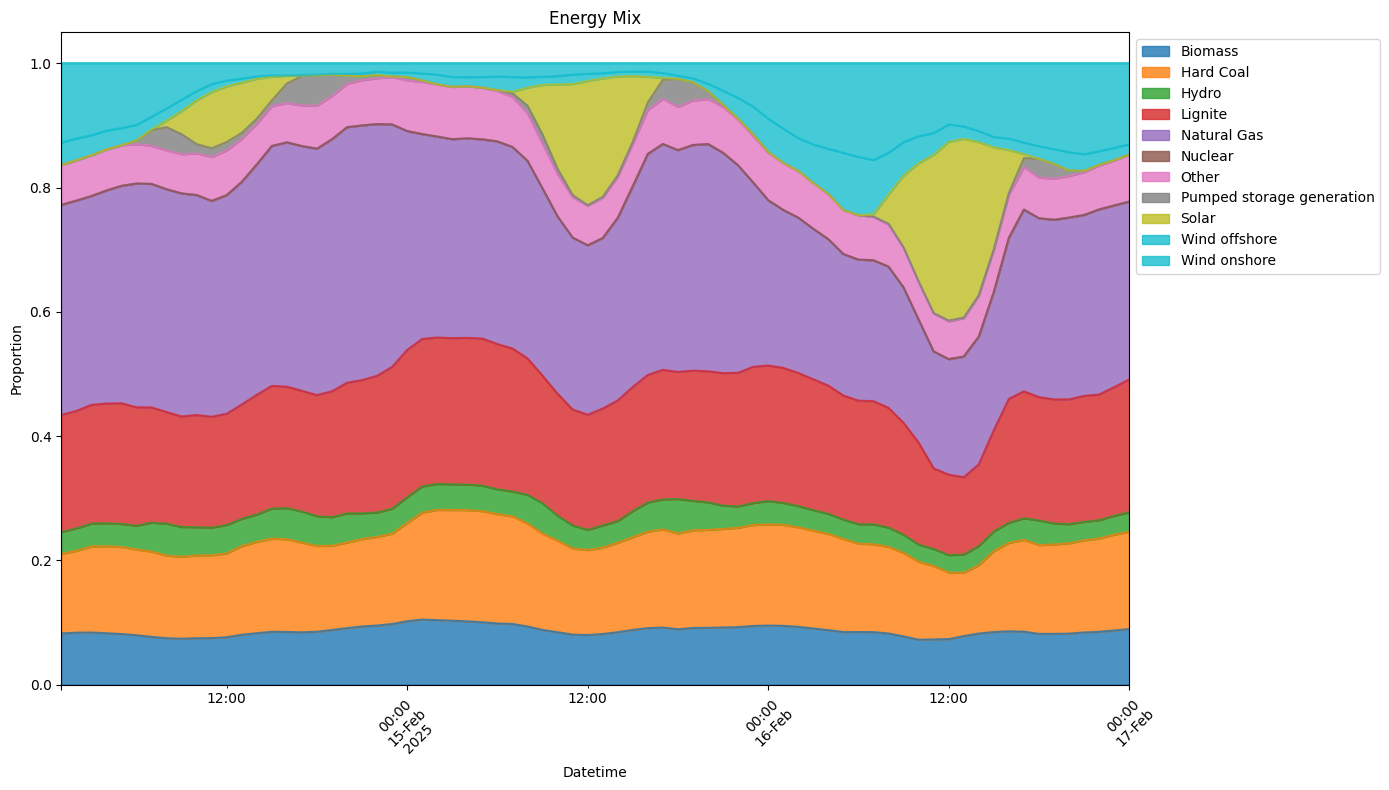

In [5]:
plot_energy_mix()

### 1.3 Weather Impacts
Weather conditions significantly influence both the supply and demand for electricity, shaping energy prices in the process. Several key factors determine these effects:

- Wind Power
  - Wind energy generation depends on steady wind speeds. High wind speeds can result in high energy production. However, if the wind is to strong, energy production ceases. In northern Germany, where wind resources are abundant, higher wind speeds typically increase supply and lower wholesale electricity prices.
- Solar Power
  - Solar energy output depends on the amount of direct radiation. Intense sunlight, especially in southern Germany, boosts solar power generation and can also drive electricity prices down.
- Hydropower
  - Electricity generation from hydropower is influenced by precipitation levels.

- Temperature changes drive electricity demand, which in turn affects prices:
  - Cold weather increases demand for heating, pushing prices higher.
  - Hot weather raises cooling demand, also driving up prices.

## 2. Data Integration

Retrieving, understanding and preparing the data is a crucial step in any predictive modeling task. In energy price forecasting, data reliability, completeness, and structure play a fundamental role in ensuring the models can capture key trends and dependencies. Given the complexity of the energy market, multiple data sources were used, each contributing essential information. However, some critical datasets were not readily accessible—gas and oil price data were behind a paywall or not availble in the required resolution. Electricity demand data was available but consistently missing the last three days, making it unsuitbale for modeling. Addressing these challenges required careful data cleaning, merging, and feature engineering to build a robust foundation for forecasting models.


## 2.1 Data Sources & Reliabality

Ensuring the reliability of data sources is fundamental in energy price modeling. The datasets used in this analysis are sourced from reputable organizations: Energy prices are sourced from SMARD.de, a platform operated by the German Federal Network Agency, which is recommended for energy price data. Weather data is obtained from Open-Meteo, a provider of historical and forecast weather information that collaborates with national weather services. Data on the energy mix is provided by Agora Energiewende, which offers interactive tools and datasets widely used for analyzing energy mix information. (SMARD, 2025) (Agora Energiewende, 2025)


## Data Preparation and Cleaning  

To ensure the datasets were ready for analysis, a comprehensive data cleaning process was conducted. This involved handling missing data, managing outliers, and merging various datasets.

### Handling Missing Data  

One of the primary challenges in data preparation was dealing with missing values. The approach varied depending on the dataset.  

For the energy mix and energy price data, rows containing missing entries in either column were removed to maintain data integrity. A special case arose with nuclear energy data, which was no longer reported after April 15, 2023, due to Germany’s nuclear phase-out. To ensure consistency, all missing nuclear values from that point onward were set to 0.0.  

The weather dataset was complete, so no additional imputation was necessary.  

The energy price dataset, required some None value removal but was complete otherwise.

### Outlier Management  

Given the volatility of energy prices, a nuanced approach was taken for outlier handling. Instead of outright removal, extreme values were assessed for their impact on model performance.  

For statistical tests, the Interquartile Range (IQR) method was used to identify and exclude extreme values. For model training, a manual outlier removal approach was implemented using a slider in the “Configuration” interface, allowing for precise control over which data points to retain. 

### Dataset Merging and Synchronization  

After cleaning the data, different datasets were merged to create a structured and comprehensive dataset for modeling. Weather data, energy price data, and energy mix data were aligned by date to ensure consistency across variables. This alignment was crucial for meaningful feature extraction and accurate analysis in the subsequent modeling phase.  


## 2.3 Hypothesis
We hypothesize that there is an inverse relationship between renewable energy production (including solar, wind onshore, wind offshore, and hydro) and next-day energy prices. In other words, as renewable generation increases, the day-ahead market price tends to decrease, largely due to the low marginal costs associated with renewable sources.

## 2.4 Hypothesis Testing

We explored the relationship between different factors (weather variables, energy mix) and energy prices.

### Null-hypothesis 
There exist no inverse relationship between Renewable energy sources (solar, wind onshore, wind offshore) and next-day energy prices


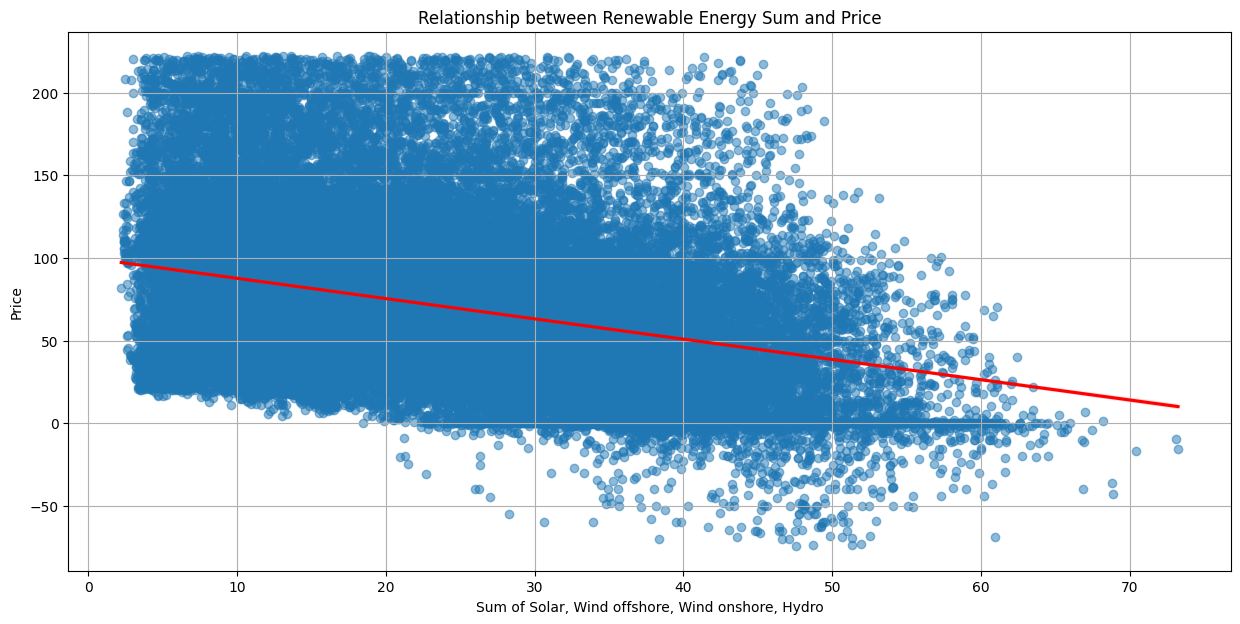

Test Score:  -0.3070221857253412
One Tailed P-Value:  1.1102230246251565e-16


In [6]:
correlation_analysis()

### r = -0.312
The correlation coefficient of -0.312 suggests a moderate negative correlation between the summed renewable energy production and the Energy Price.
This means that as renewable energy generation increases, energy prices tend to decrease, albeit with some variability.
The magnitude of the correlation (around 0.3) indicates a moderate linear relationship.

### P-Value ≈ 0
The extremely small p-value suggests that the observed negative correlation is highly statistically significant.
In practical terms, this means that the probability of obtaining such a correlation by random chance under the null hypothesis (that there is no correlation) is virtually zero.
Given this result we can reject the null hypothesis and conclude that the negative relationship between renewable energy generation and prices is statistically significant.

### Practical Interpretation:
The negative correlation suggests that an increase in renewable energy production (solar, wind, hydro) could be associated with lower electricity prices. This aligns with expectations, as renewable energy sources typically have lower marginal costs compared to fossil fuels, which can lead to lower market prices when their availability is high.
However, the moderate strength of the correlation (r = -0.312) indicates that while the relationship exists, other factors (e.g., demand fluctuations, fossil fuel prices, regulatory policies) might also influence the price.

In [7]:
merged_df, e_price_df = get_datasets()

## Configuration


In [8]:
price_interval, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-20, 400), continuous_update=False, description='Energy Price Interval', max=900, min=-5…

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## 3. Features
Selecting relevant features is crucial for building an effective predictive model. Given the diverse range of available data—including time-based attributes, moving averages, energy generation sources, and weather variables—our selection process focused on maximizing predictive power while avoiding redundancy. Since energy prices exhibit strong temporal dependencies, time-based features were incorporated to capture seasonal and weekly patterns. The importance of these features has been previously discussed in the context of price dynamics (see Section 1.1.1). Additionally, moving averages played a key role in smoothing short-term fluctuations and enhancing model stability, as outlined in Section 3.1. Beyond time-related attributes, energy mix variables were selected based on their direct impact on electricity prices. Renewable energy sources, particularly solar and hydro, were included due to their well-documented influence on price formation. Weather variables, such as temperature, precipitation, and direct radiation, were chosen for their role in both energy demand and renewable generation variability. These relationships have been analyzed in Section 1.1.3, reinforcing their relevance in predictive modeling. By carefully curating our feature set, we ensured that the model balances complexity and interpretability while capturing the fundamental drivers of energy price fluctuations. This selection process aimed to improve forecasting accuracy without introducing unnecessary computational overhead.


## 3.1 Moving Averages and Their Role in Forecasting
Moving averages are essential for smoothing out short-term fluctuations in time-series data and revealing underlying trends. By averaging values over a defined window, moving averages reduce noise and enhance the visibility of long-term patterns.
For linear regression-based models, moving averages provide several benefits:
- *Noise Reduction*: Energy price data can be volatile due to external shocks, market fluctuations, and unexpected demand surges. Moving averages help smooth these fluctuations, enabling the model to focus on broader trends rather than reacting to random variations.
- *Feature Engineering*: Moving averages can serve as additional explanatory variables in regression models, capturing smoothed past behavior that informs future predictions.
Seasonality Handling: By choosing appropriate window sizes (e.g., 24-hour, 7-day, or 30-day moving averages), it is possible to better capture daily, weekly, or monthly cycles in energy prices.
- *Enhanced Interpretability*: Linear models often struggle with high-frequency variations. Incorporating moving averages helps them generalize better by reducing the emphasis on short-term noise.
Given the time-series nature of energy prices, we applied moving averages with various window sizes (e.g., hourly and daily) to analyze how different trends affect price fluctuations. This was particularly useful in identifying seasonal effects and ensuring that models could make robust predictions without overfitting to short-term anomalies.

In [9]:
get_features, default_features = select_features()

GridBox(children=(Checkbox(value=True, description='hour'), Checkbox(value=True, description='dayofyear'), Che…

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [11]:
# RERUN WHEN TICKING the NORMALIZED BOX
min_price, max_price = price_interval.value

(
    train,
    eval,
    test,
    benchmark,
    SPLIT_DATE_EVAL,
    SPLIT_DATE_TEST,
    SPLIT_DATE_BENCHMARK,
    train_interval,
    eval_interval,
    test_interval,
    benchmark_interval,
    SPLIT_DATE_EVAL_INTERVAL,
    SPLIT_DATE_TEST_INTERVAL,
    SPLIT_DATE_BENCHMARK,
    scalar,
    FEATURES
) = create_features_and_split_datasets(
    merged_df.copy(),
    default_features,
    get_features(),
    min_price,
    max_price,
    e_price_df.copy(),
    normalize.value,
    eval_size.value,
)


(   X_train, y_train, X_val, y_val, X_test, y_test,
    X_train_interval,
    y_train_interval,
    X_val_interval,
    y_val_interval,
    X_test_interval,
    y_test_interval,
) = get_sets(train, eval, test, train_interval, eval_interval, test_interval, FEATURES)

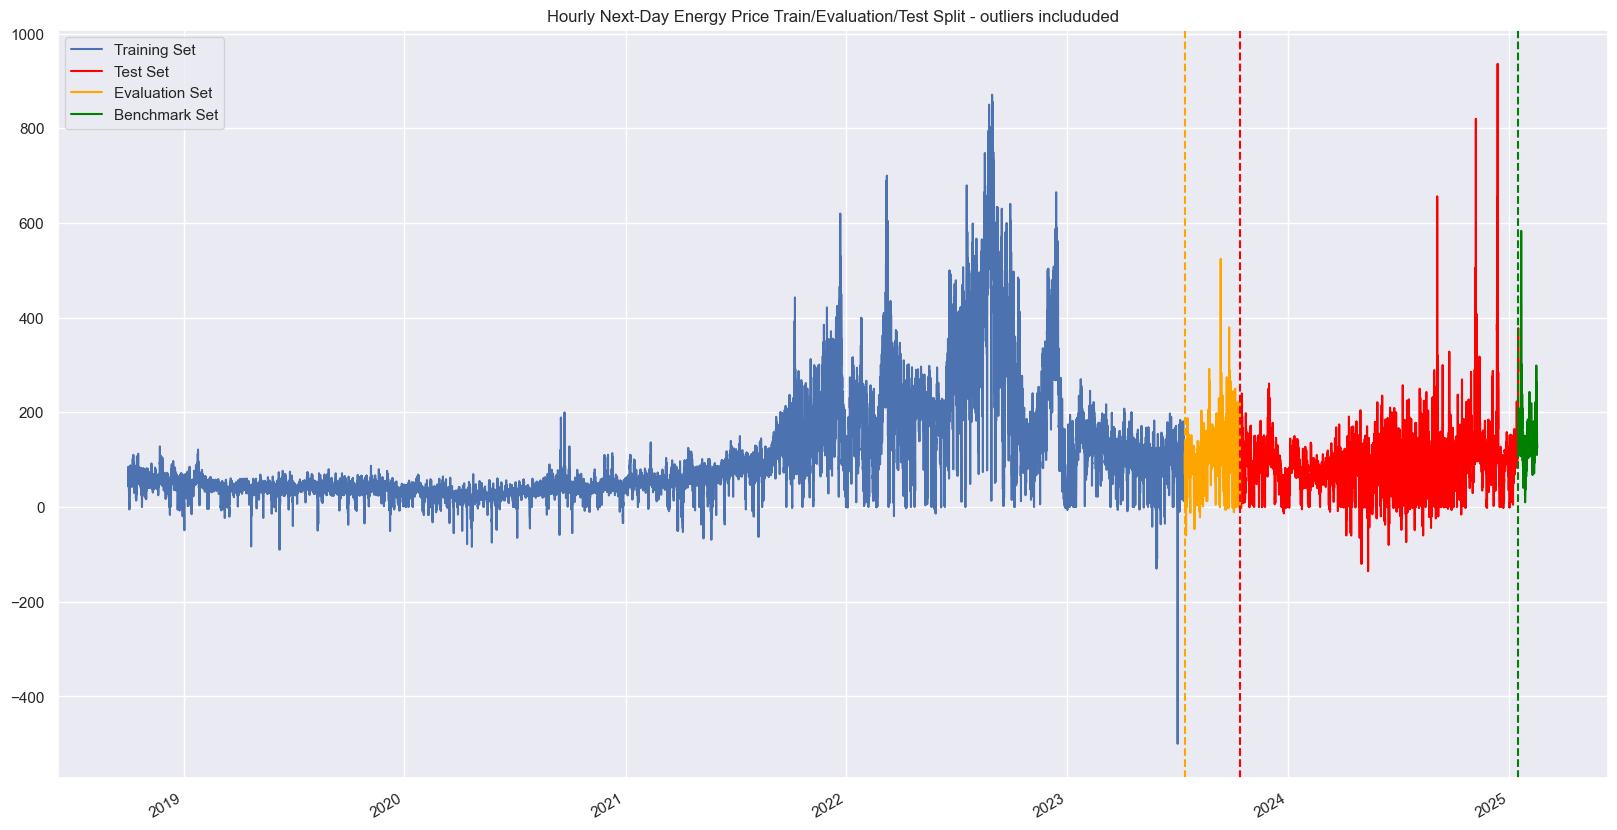

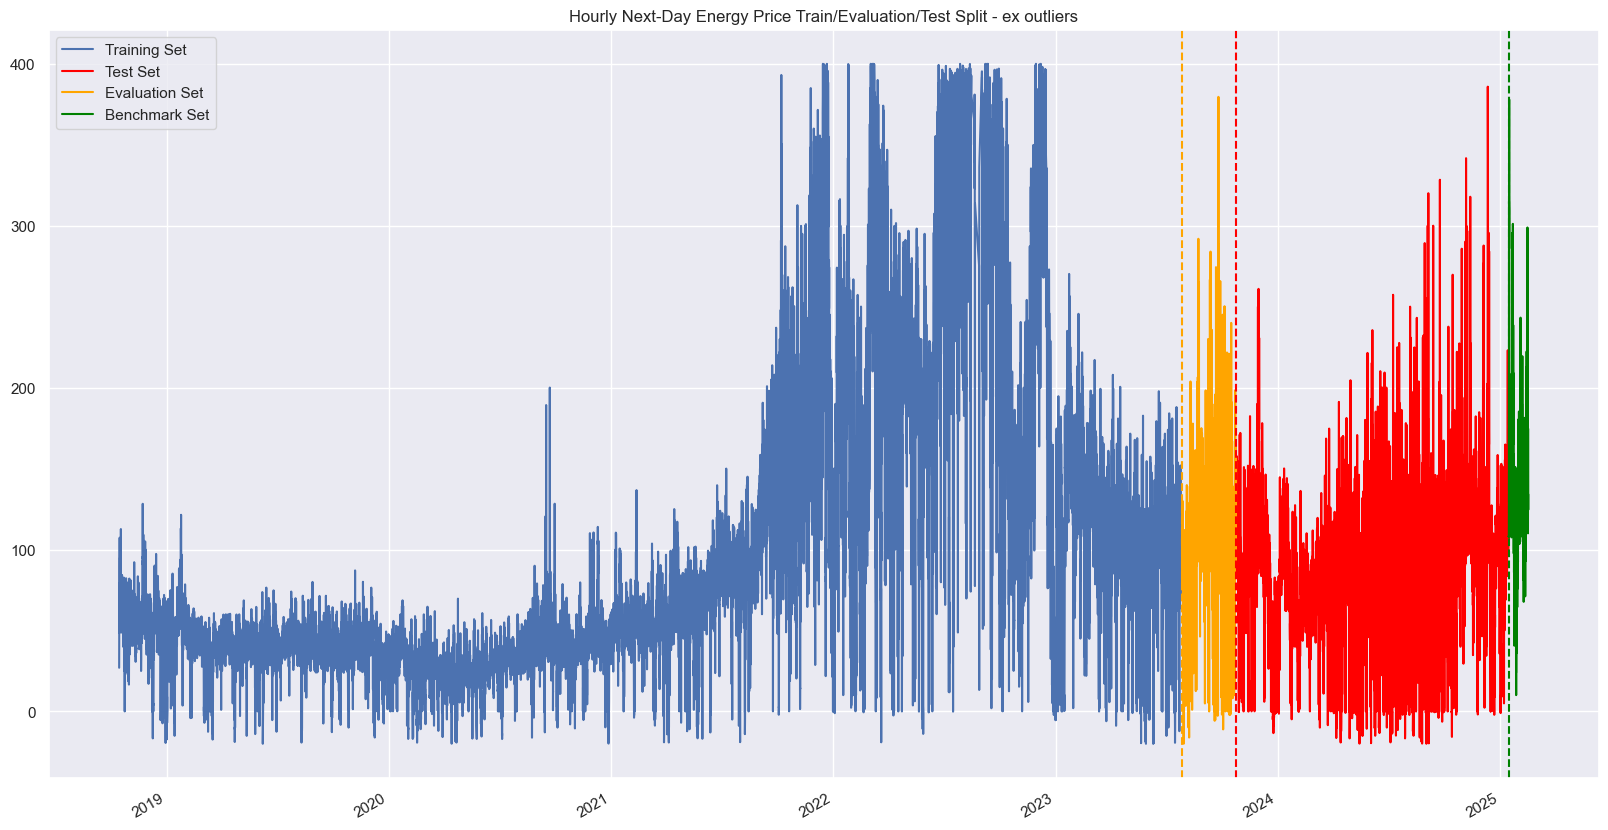

In [10]:
plot_price_split(train, eval, test, benchmark, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, SPLIT_DATE_BENCHMARK, "outliers includuded")
plot_price_split(train_interval, eval_interval, test_interval, benchmark_interval, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, SPLIT_DATE_BENCHMARK, "ex outliers")

## 3.2 Evaluation Criteria

To assess model performance, we considered the following:
1. Error Objectiv Functions
- RMSE (Root Mean Squared Error): Measures overall prediction error, with a stronger penalty for large deviations.
- MAE (Mean Absolute Error): Reflects the average magnitude of errors without emphasizing outliers as strongly as RMSE.
- MSE (Mean Squared Error): Calculates the average of the squared differences between actual and predicted values, providing a general measure of error while penalizing larger errors more than MAE.
- MAPE (Mean Absolute Percentage Error): Expresses the average absolute error as a percentage of actual values, making it useful for comparing errors across different scales or datasets.
2. Handling of Seasonality and Outliers
- The ability to capture daily, weekly, and yearly seasonality effectively.
- Robustness to price spikes and outliers due to external factors like demand surges or market shocks.
3. Ease of Interpretation
- Linear models like Regression provide direct insight into feature importance.
- Prophet allows for intuitive trend and seasonality decomposition.
- XGBoost requires careful feature engineering to extract meaningful insights.
4. Faster Iteration and Scalability
- Training time and computational efficiency.
- Ability to adapt and fine-tune hyperparameters efficiently.



## 4 Model Selection and Training

Selecting an appropriate modeling approach is a critical step in building a reliable forecasting system. Given the complexity of energy price dynamics, the choice of models must balance accuracy, interpretability, and computational efficiency. A well-defined modeling strategy typically begins with a simple yet effective baseline model before progressing to more advanced techniques. This ensures that improvements gained from sophisticated models are measured against a meaningful reference point. In this section, we outline the reasoning behind our model selection process, beginning with a baseline model and advancing to more specialized forecasting methods.

## 4.1 Choosing a Baseline Model
For our initial baseline model, we selected Linear Regression due to its simplicity, interpretability, and computational efficiency. Linear Regression provides a straightforward approach to capturing linear relationships in the data, making it an excellent reference point for evaluating more complex models. However, it struggles with capturing non-linear dependencies and seasonality, which are crucial in energy price forecasting.
We opted against using neural networks due to several reasons:
- **Computational Cost**: Training deep learning models requires significant computational resources, which were not justified given the available dataset size and forecasting horizon.
- **Interpretability**: Neural networks act as black-box models, making it difficult to extract insights about seasonal trends, price spikes, or external influencing factors.
- **Data Requirements**: Deep learning models typically require large amounts of high-quality data to generalize well. Given our dataset’s structure, traditional time-series models were more suitable.


In [12]:
lr_prediction = linear_regression(X_train, y_train, X_test, y_test, scalar)

## 4.2 XGBoost
XGBoost (Extreme Gradient Boosting) is a machine learning algorithm based on decision trees, well-suited for structured datasets like ours. It excels at capturing non-linear relationships, allowing it to model complex interactions between features and energy prices, which Linear Regression cannot do. XGBoost also provides built-in feature importance metrics, helping identify key factors like weather, energy mix, and demand fluctuations. It handles missing data and outliers better than traditional models, making it a robust choice for real-world forecasting. Computationally efficient compared to deep learning models, XGBoost performs well for our dataset, although it requires feature engineering and hyperparameter tuning. Its ability to capture short-term fluctuations and complex feature interactions can enhance forecasting accuracy.

Gradient Boosting is an ensemble learning technique that builds a model by iteratively improving the predictions of weak learners (typically decision trees). Each new model focuses on the errors of the previous one, reducing them in a sequential manner. This allows Gradient Boosting to handle complex patterns and interactions in the data, making it effective for tasks like forecasting energy prices.

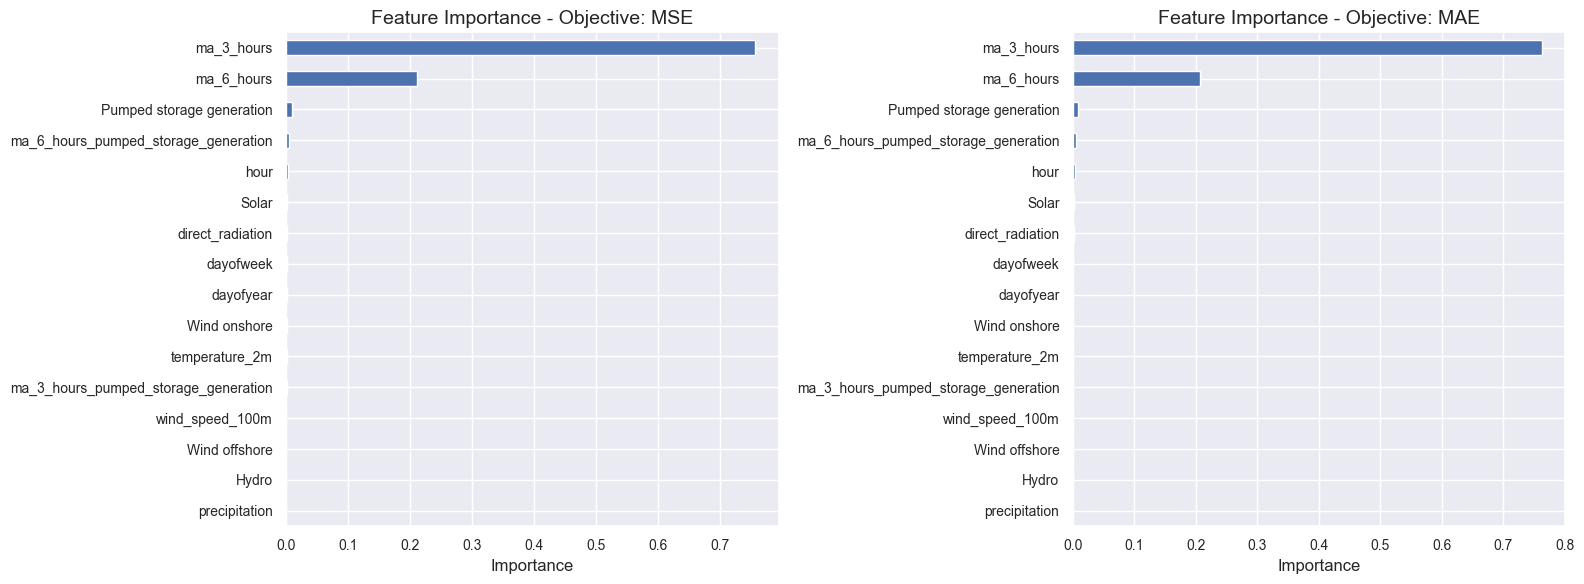

In [13]:
xgb_y_prediction_mse, xgb_mse = predict_mse(
    X_train_interval, y_train_interval, X_val_interval, y_val_interval, X_test_interval, scalar
)
xgb_y_prediction_mae, xgb_mae = predict_mae(
    X_train_interval, y_train_interval, X_val_interval, y_val_interval, X_test_interval, scalar
)

plot_feature_importance((xgb_mse, xgb_mae))

## 4.3 Prophet
Prophet, developed by Facebook, is designed for time-series forecasting, particularly in capturing seasonality, trends, and holiday effects. It automatically detects daily, weekly, and yearly seasonality, which is helpful for energy price forecasting, where such patterns dominate. Prophet is robust to missing data and outliers, improving forecast reliability. Unlike traditional models, Prophet allows trend changes over time, making it ideal for dynamic markets. It also provides clear decompositions of trend, seasonality, and holiday effects, offering interpretability that aids understanding of energy price drivers. Prophet’s combination of seasonality detection, trend flexibility, and ease of use makes it a powerful tool for forecasting energy prices.

In [14]:
prophet_prediction = prophet(FEATURES, X_train, y_train, X_test, scalar)

10:52:36 - cmdstanpy - INFO - Chain [1] start processing
10:53:02 - cmdstanpy - INFO - Chain [1] done processing


## Results

In [14]:
if scalar:
    y_test = unnormalize(y_test, scalar)

### Errors

In [15]:
calculate_error_metrics(
    y_test, y_test_interval, [lr_prediction, prophet_prediction, xgb_y_prediction_mse, xgb_y_prediction_mae]
)

            Model       MAE        MSE      RMSE         MAPE
Linear Regression  6.683900 163.637483 12.792087 1.060594e+16
          Prophet 12.164979 361.745575 19.019610 1.294123e+16
   XGBoost (RMSE)  5.789572  91.550463  9.568201 5.190262e+15
    XGBoost (MAE)  5.815041  92.909562  9.638961 4.938555e+15


### Plots

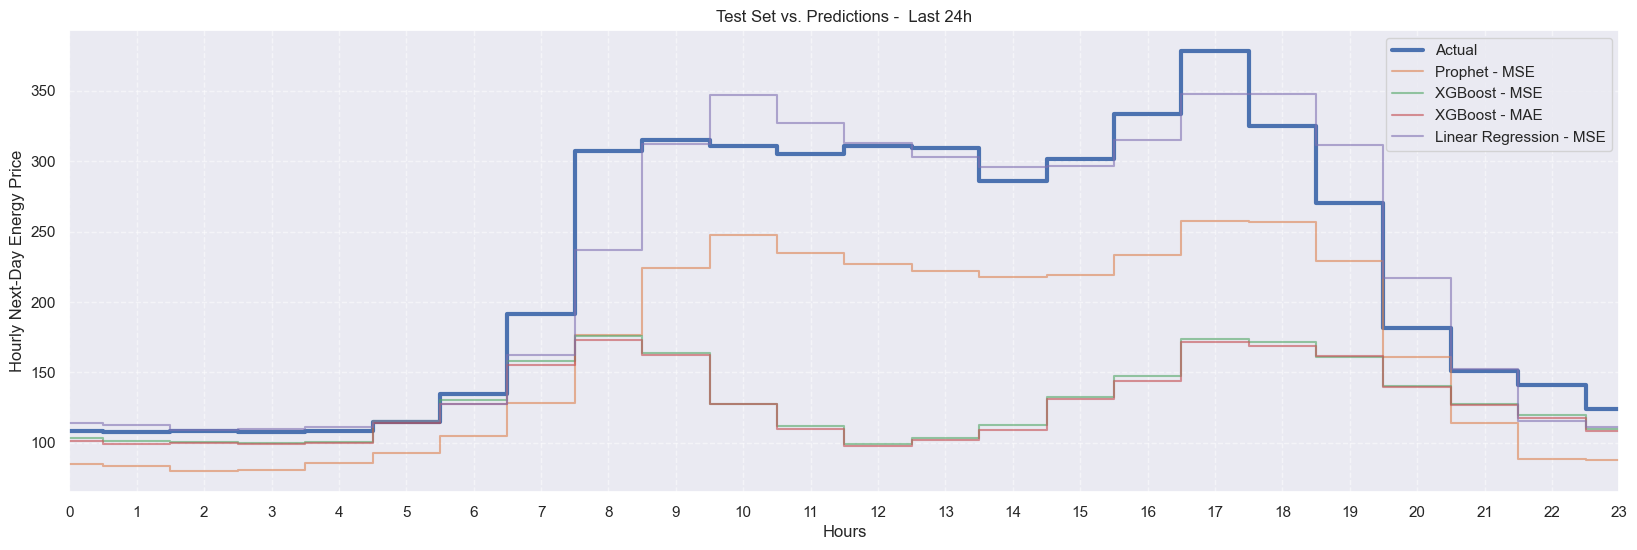

In [16]:
predictions = [
    (prophet_prediction, "Prophet", "MSE"),
    (xgb_y_prediction_mse, "XGBoost", "MSE"),
    (xgb_y_prediction_mae, "XGBoost", "MAE"),
    (lr_prediction, "Linear Regression", "MSE"),
]

plot_predicted(y_test, predictions)

## Benchmarking

## 6. Benchmark

The Benchmark Test evaluates the performance of different forecasting algorithms (Prophet, Linear Regression, and XGBoost) by simulating the prediction of the energy price on Febuary 18th.  

## Methodology  

### Data Preparation  
- The dataset is merged and split into training, evaluation, and test sets.  
- Training data includes all historical data up to a certain point.  
- Evaluation and test sets assess model performance on unseen data.  
- The benchmark dataset serves as a reference for comparing model predictions. Since we have missing values for the day of prediction, we sample energy price data from a gaussian distribution. For energy mix data we simply copy the values from the previous day. OpenMeteo provides weather prediction for the upcoming day. We therefore don't have to rely on sampling or copying of preivous data.  

### Rolling Forecast Loop  
- The dataset is processed in 24-hour intervals.  
- Starting 24 hours before the target day, the loop moves in 24-hour steps, predicting the price for the target day each time.  
- The models are retrained on all available data up to each step, expanding the dataset continuously.  
- If data is missing, the forecast for that window is skipped.  

## Model Evaluation  

- In each iteration, the three models (Prophet, Linear Regression, XGBoost) are trained and used to predict the price for one day.  
- After running all simulations, the results are aggregated.  
- The average RMSE (Root Mean Square Error) is calculated for each model.  
- The model with the lowest RMSE is selected as the best model for predicting the energy price on February 18th.  

## Significance of the Benchmark Test  

The Benchmark Test Setup helps simulate real-world forecasting conditions by continuously training and testing models over time. By comparing RMSE values, we can objectively determine which model provides the most accurate prediction for the target date.

  0%|          | 0/30 [00:00<?, ?it/s]


Date to predict:  2025-01-17 00:00:00


10:11:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:03 - cmdstanpy - INFO - Chain [1] done processing


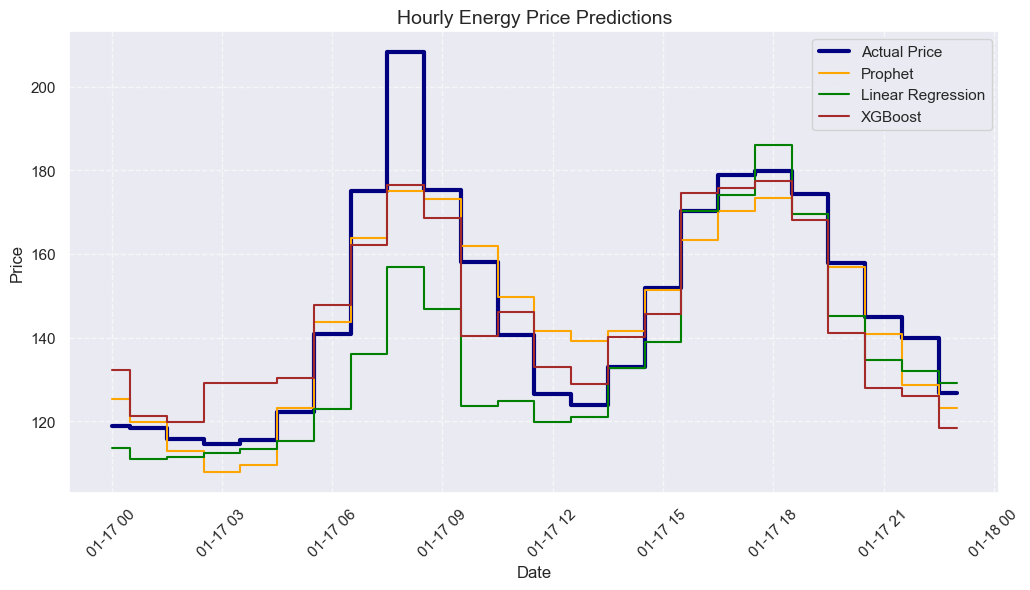

  3%|▎         | 1/30 [01:11<34:47, 71.98s/it]

Prophet RMSE: 9.868062456476185
Linear Regression RMSE: 17.65254297353897
XGBoost RMSE: 11.78481167838427
--------------------------------------------------------

Date to predict:  2025-01-18 00:00:00


10:12:26 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing


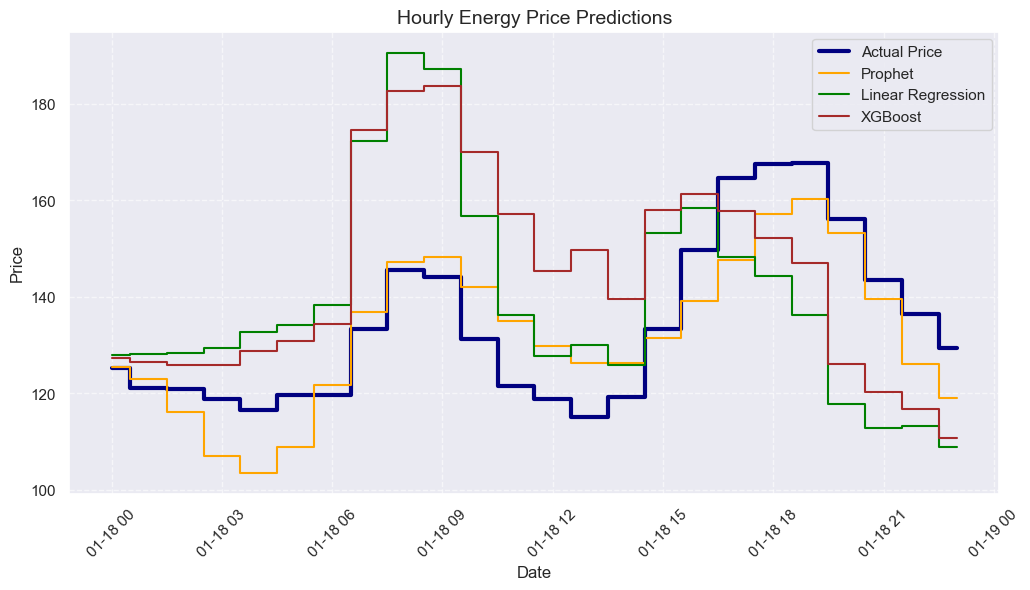

  7%|▋         | 2/30 [02:16<31:29, 67.47s/it]

Prophet RMSE: 8.85943132225979
Linear Regression RMSE: 23.536691167196874
XGBoost RMSE: 24.11981633064153
--------------------------------------------------------

Date to predict:  2025-01-19 00:00:00


10:13:31 - cmdstanpy - INFO - Chain [1] start processing
10:14:09 - cmdstanpy - INFO - Chain [1] done processing


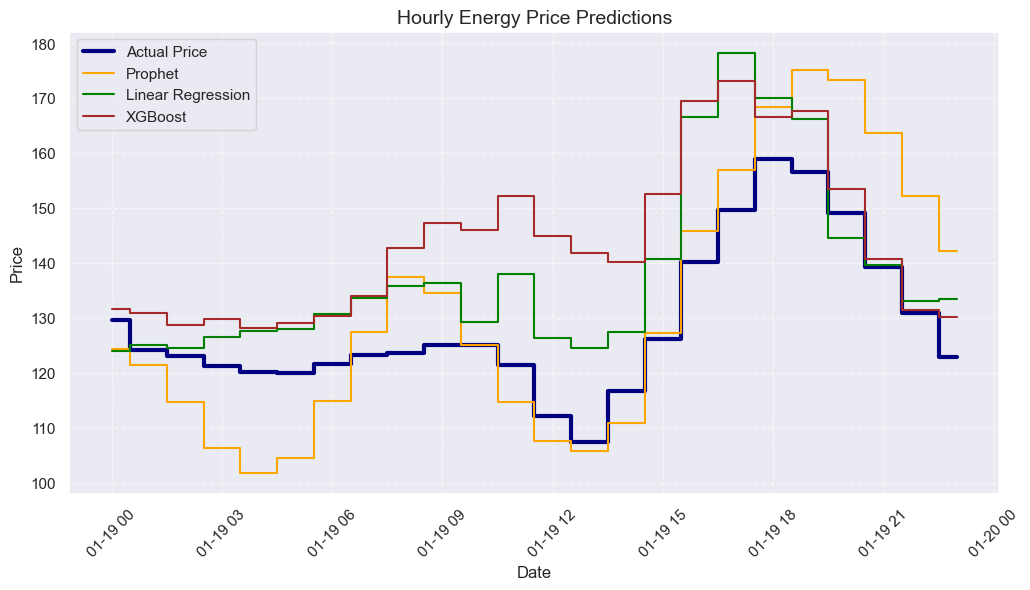

 10%|█         | 3/30 [03:19<29:27, 65.47s/it]

Prophet RMSE: 12.699570820590631
Linear Regression RMSE: 12.266052244041544
XGBoost RMSE: 18.119780807792104
--------------------------------------------------------

Date to predict:  2025-01-20 00:00:00


10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:15 - cmdstanpy - INFO - Chain [1] done processing


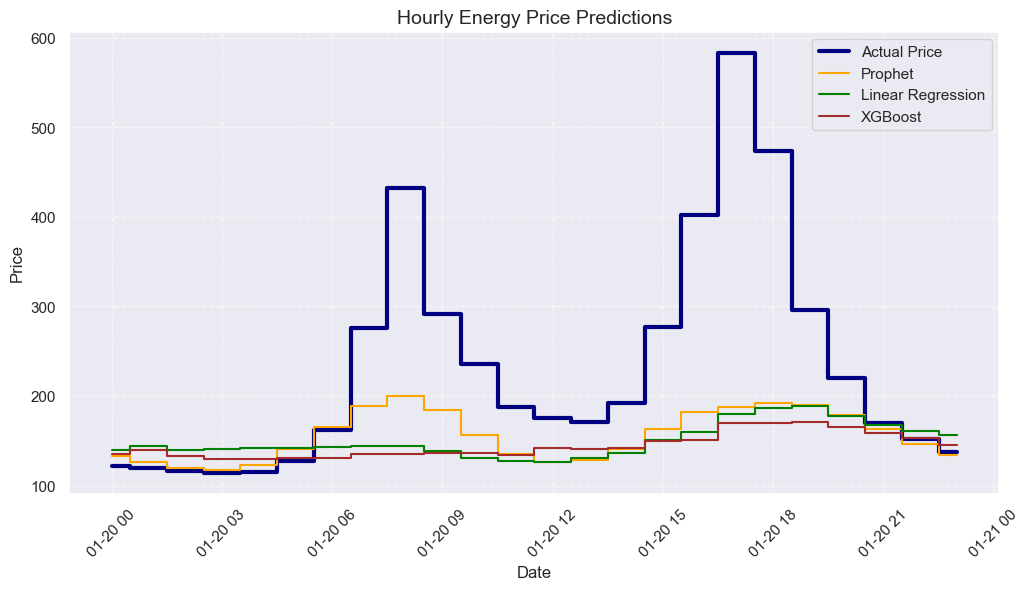

 13%|█▎        | 4/30 [04:23<28:07, 64.90s/it]

Prophet RMSE: 128.86443740533048
Linear Regression RMSE: 141.74194967263537
XGBoost RMSE: 146.18718573134862
--------------------------------------------------------

Date to predict:  2025-01-21 00:00:00


10:15:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing


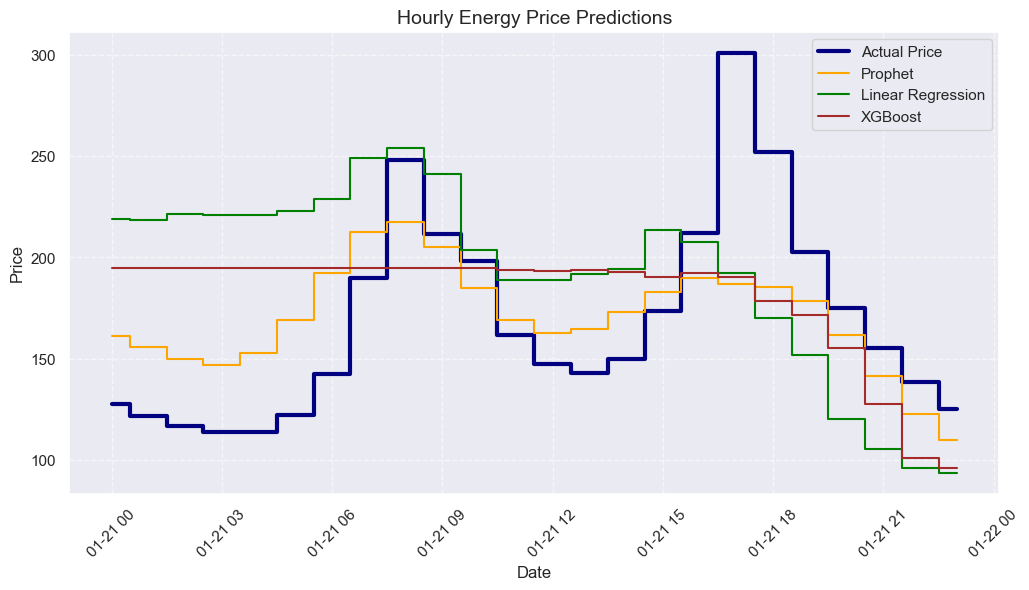

 17%|█▋        | 5/30 [05:28<27:03, 64.92s/it]

Prophet RMSE: 37.2364420478922
Linear Regression RMSE: 68.19237597666483
XGBoost RMSE: 54.23138422190667
--------------------------------------------------------

Date to predict:  2025-01-22 00:00:00


10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing


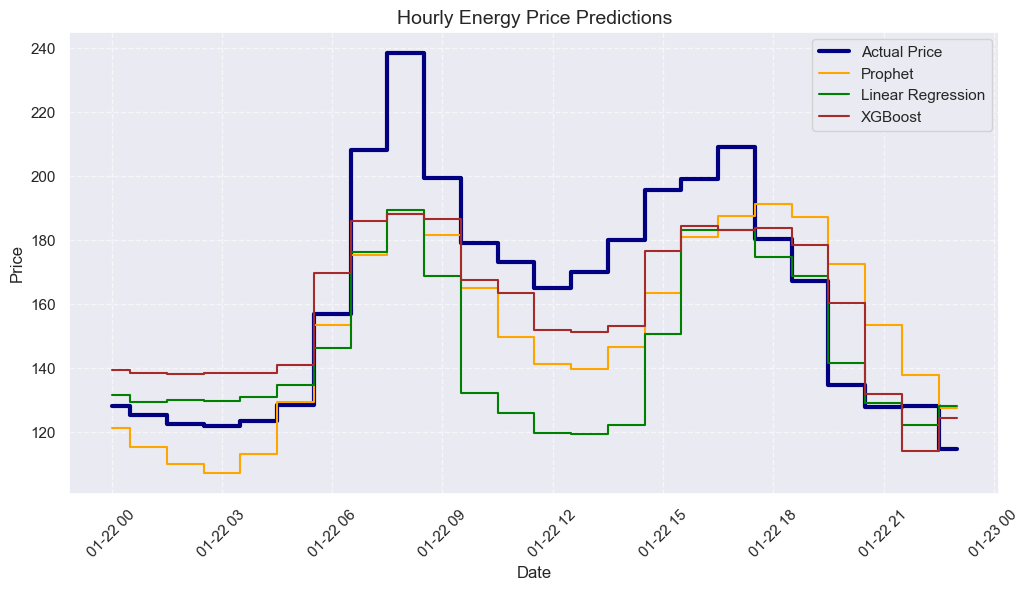

 20%|██        | 6/30 [06:36<26:27, 66.15s/it]

Prophet RMSE: 22.94807859133714
Linear Regression RMSE: 29.14510499105661
XGBoost RMSE: 18.757756041709673
--------------------------------------------------------

Date to predict:  2025-01-23 00:00:00


10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:38 - cmdstanpy - INFO - Chain [1] done processing


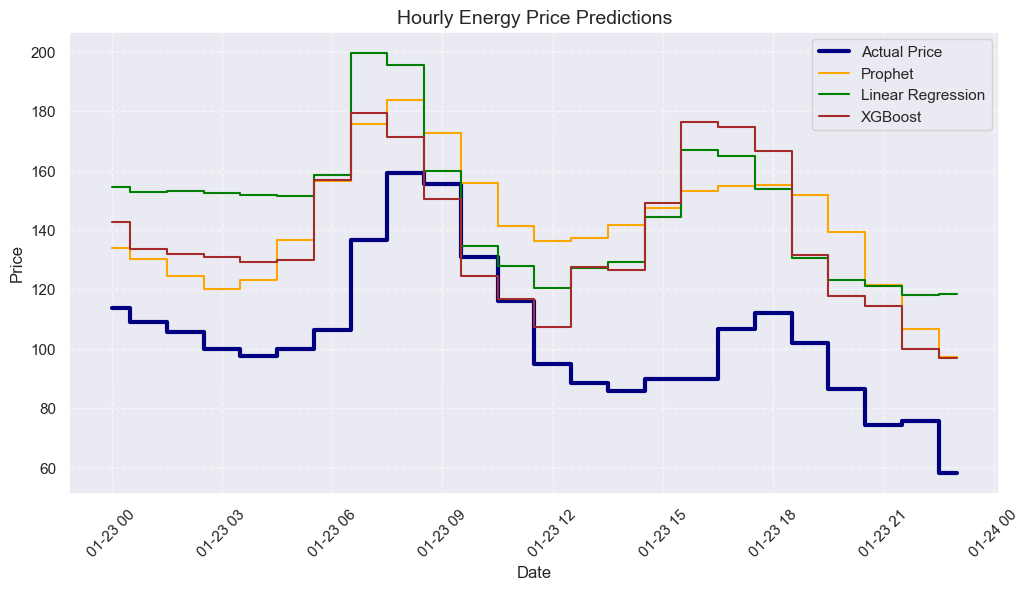

 23%|██▎       | 7/30 [07:50<26:15, 68.49s/it]

Prophet RMSE: 40.077712626881045
Linear Regression RMSE: 45.773879573360794
XGBoost RMSE: 39.300541720177385
--------------------------------------------------------

Date to predict:  2025-01-24 00:00:00


10:19:05 - cmdstanpy - INFO - Chain [1] start processing
10:19:50 - cmdstanpy - INFO - Chain [1] done processing


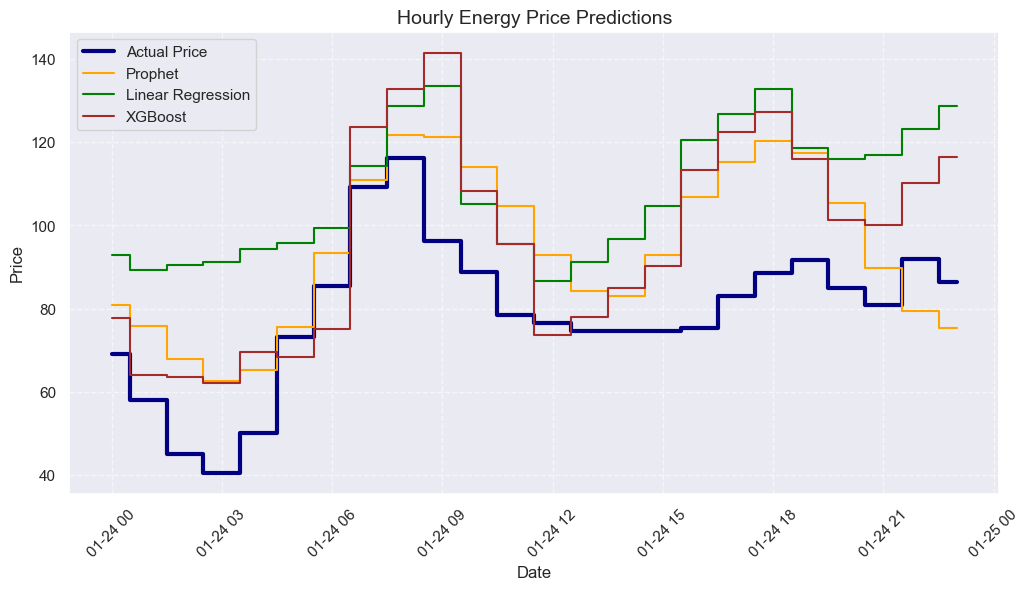

 27%|██▋       | 8/30 [09:01<25:28, 69.48s/it]

Prophet RMSE: 19.3531827769893
Linear Regression RMSE: 31.849906824428576
XGBoost RMSE: 22.312768223910993
--------------------------------------------------------

Date to predict:  2025-01-25 00:00:00


10:20:16 - cmdstanpy - INFO - Chain [1] start processing
10:21:02 - cmdstanpy - INFO - Chain [1] done processing


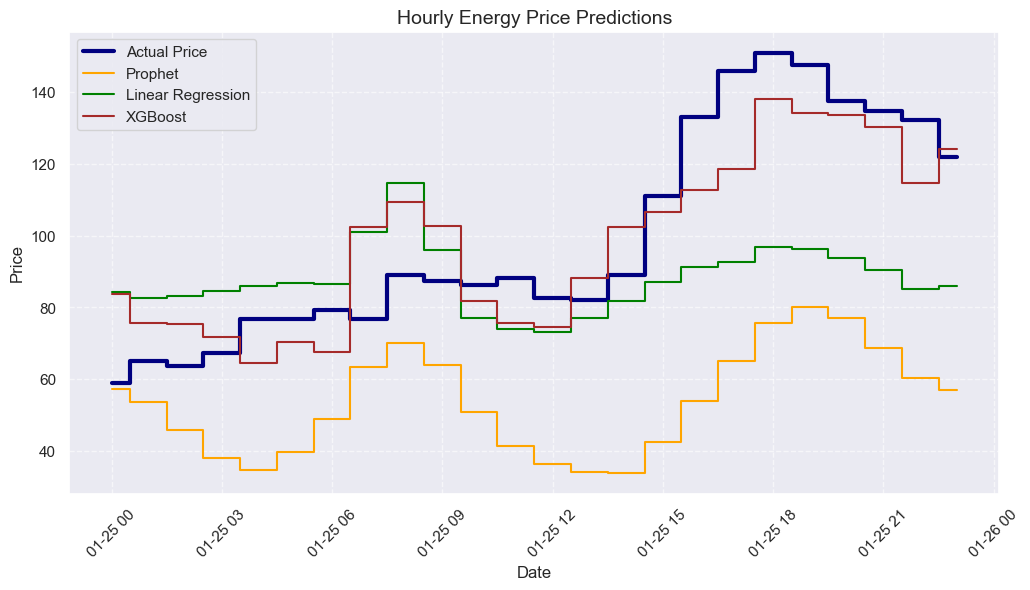

 30%|███       | 9/30 [10:14<24:37, 70.35s/it]

Prophet RMSE: 51.04474726364334
Linear Regression RMSE: 30.078165552417673
XGBoost RMSE: 14.222275918894914
--------------------------------------------------------

Date to predict:  2025-01-26 00:00:00


10:21:28 - cmdstanpy - INFO - Chain [1] start processing
10:22:11 - cmdstanpy - INFO - Chain [1] done processing


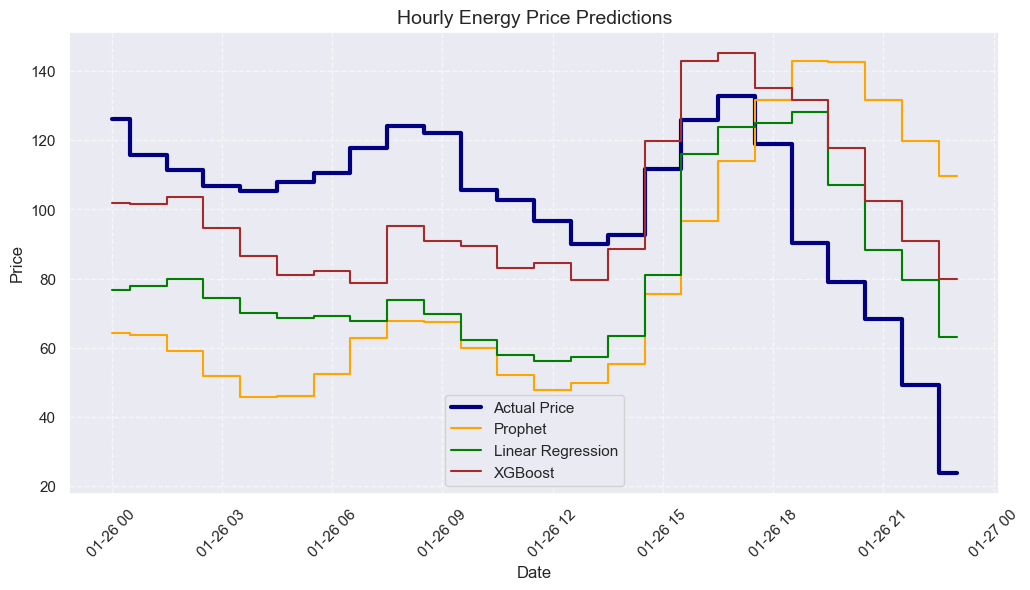

 33%|███▎      | 10/30 [11:19<22:55, 68.78s/it]

Prophet RMSE: 53.2858097495714
Linear Regression RMSE: 36.45528598812914
XGBoost RMSE: 26.72057676848398
--------------------------------------------------------

Date to predict:  2025-01-27 00:00:00


10:22:34 - cmdstanpy - INFO - Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing


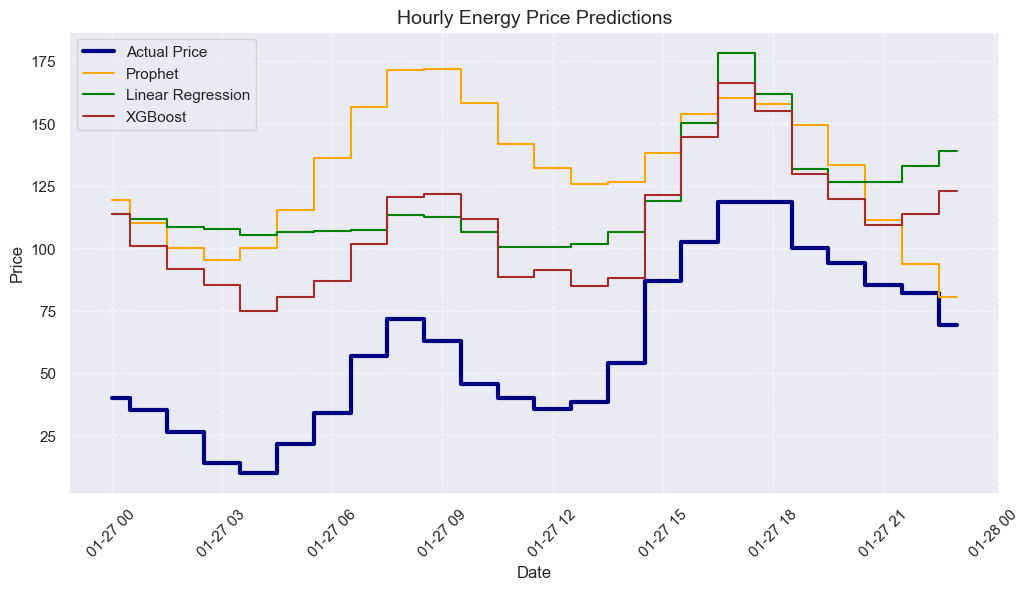

 37%|███▋      | 11/30 [12:35<22:32, 71.18s/it]

Prophet RMSE: 76.8379314163522
Linear Regression RMSE: 62.39141352686447
XGBoost RMSE: 51.22562718828329
--------------------------------------------------------

Date to predict:  2025-01-28 00:00:00


10:23:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:34 - cmdstanpy - INFO - Chain [1] done processing


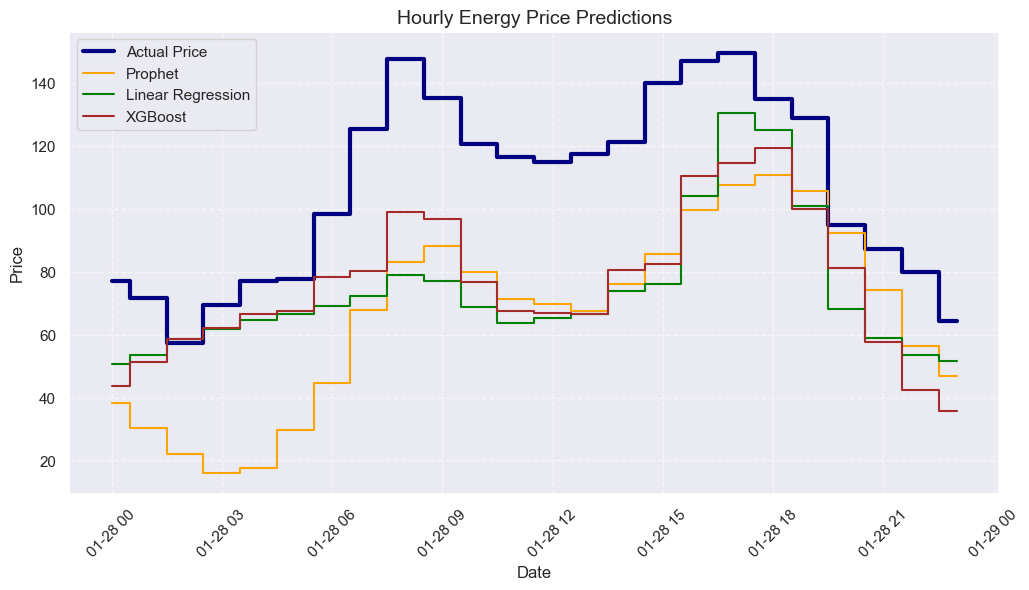

 40%|████      | 12/30 [13:46<21:16, 70.91s/it]

Prophet RMSE: 43.319373960334296
Linear Regression RMSE: 38.40878376124397
XGBoost RMSE: 34.889150584932736
--------------------------------------------------------

Date to predict:  2025-01-29 00:00:00


10:25:01 - cmdstanpy - INFO - Chain [1] start processing
10:25:46 - cmdstanpy - INFO - Chain [1] done processing


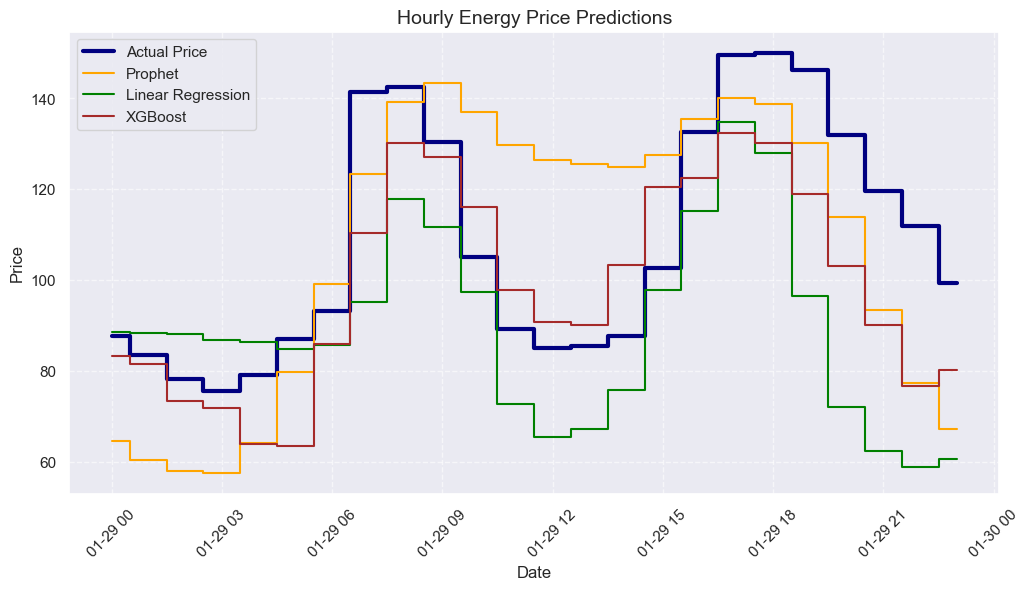

 43%|████▎     | 13/30 [14:58<20:11, 71.27s/it]

Prophet RMSE: 24.442765317467316
Linear Regression RMSE: 28.407736294613542
XGBoost RMSE: 17.904058946694885
--------------------------------------------------------

Date to predict:  2025-01-30 00:00:00


10:26:13 - cmdstanpy - INFO - Chain [1] start processing
10:26:58 - cmdstanpy - INFO - Chain [1] done processing


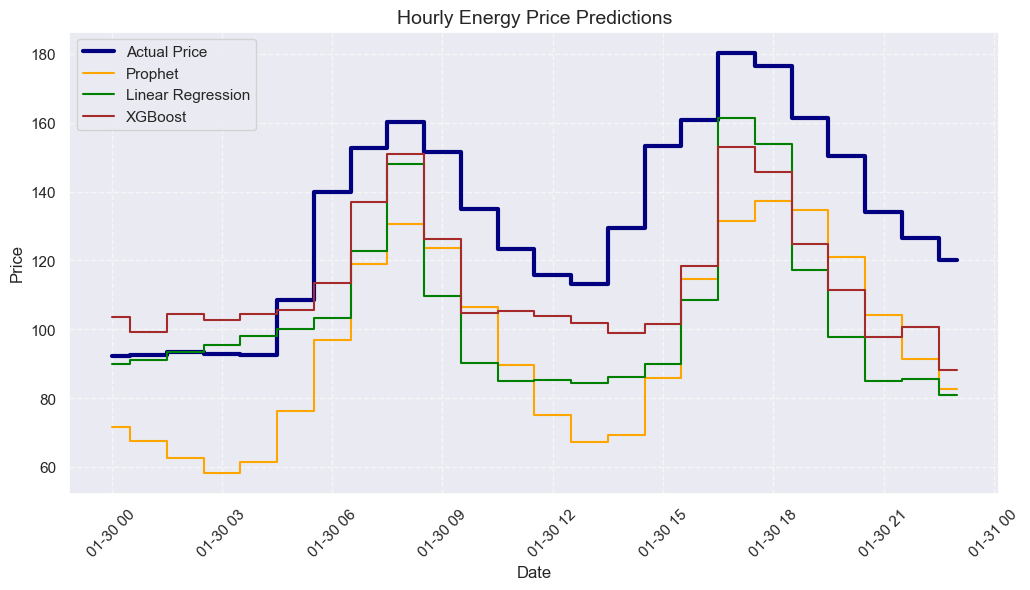

 47%|████▋     | 14/30 [16:10<19:06, 71.63s/it]

Prophet RMSE: 38.10585192842197
Linear Regression RMSE: 34.94066091507948
XGBoost RMSE: 26.366932419253775
--------------------------------------------------------

Date to predict:  2025-01-31 00:00:00


10:27:25 - cmdstanpy - INFO - Chain [1] start processing
10:28:21 - cmdstanpy - INFO - Chain [1] done processing


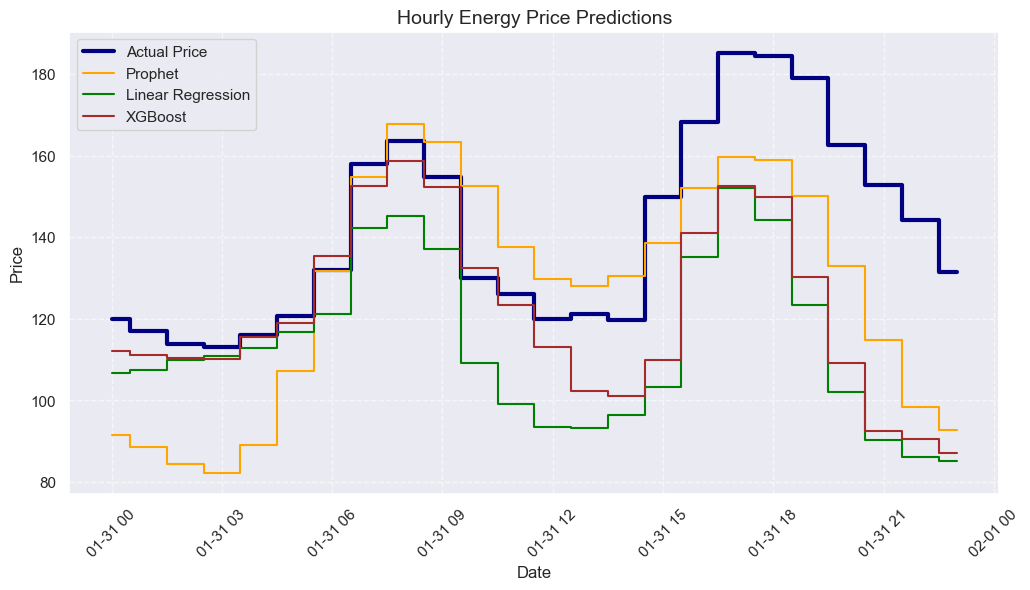

 50%|█████     | 15/30 [17:33<18:45, 75.07s/it]

Prophet RMSE: 23.977205823074048
Linear Regression RMSE: 33.35450421623512
XGBoost RMSE: 28.350966679095524
--------------------------------------------------------

Date to predict:  2025-02-01 00:00:00


10:28:48 - cmdstanpy - INFO - Chain [1] start processing
10:29:28 - cmdstanpy - INFO - Chain [1] done processing


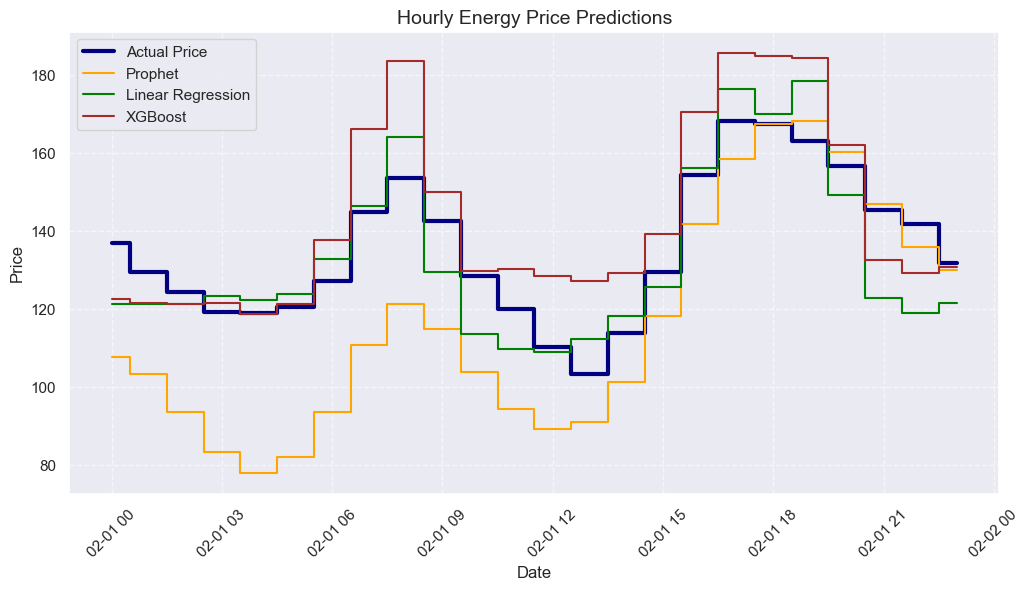

 53%|█████▎    | 16/30 [18:40<16:56, 72.57s/it]

Prophet RMSE: 23.686549771154727
Linear Regression RMSE: 10.443829979058425
XGBoost RMSE: 14.173130809015104
--------------------------------------------------------

Date to predict:  2025-02-02 00:00:00


10:29:55 - cmdstanpy - INFO - Chain [1] start processing
10:30:48 - cmdstanpy - INFO - Chain [1] done processing


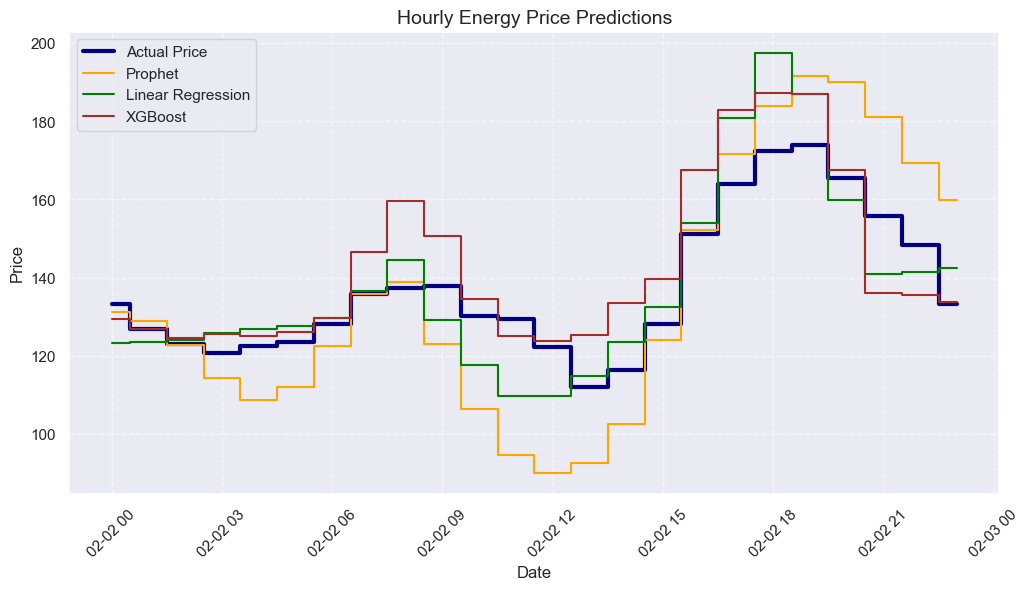

 57%|█████▋    | 17/30 [19:59<16:09, 74.57s/it]

Prophet RMSE: 16.992167780489787
Linear Regression RMSE: 10.321229981585754
XGBoost RMSE: 11.275403221005854
--------------------------------------------------------

Date to predict:  2025-02-03 00:00:00


10:31:15 - cmdstanpy - INFO - Chain [1] start processing
10:31:57 - cmdstanpy - INFO - Chain [1] done processing


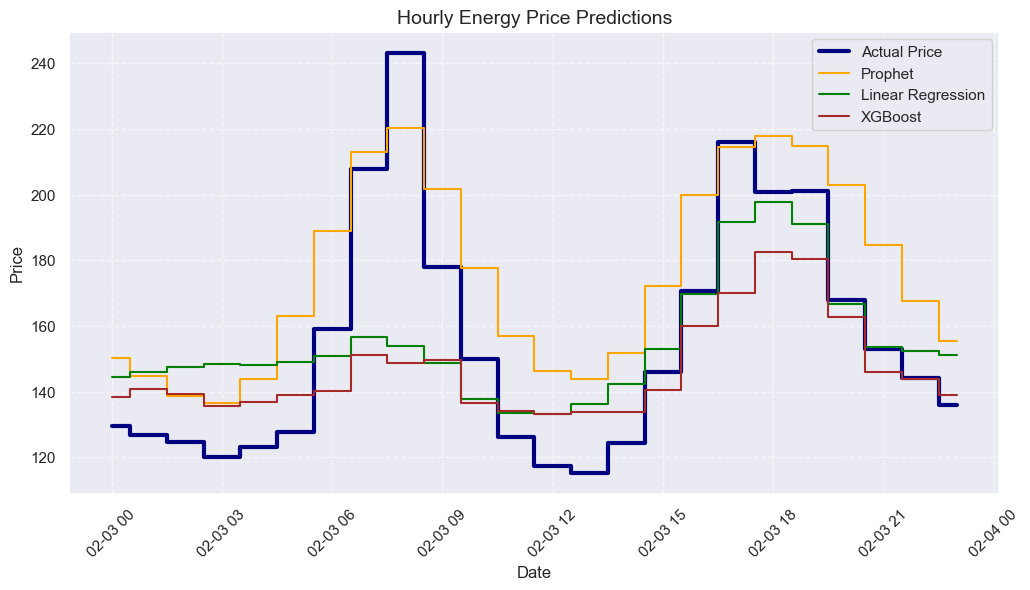

 60%|██████    | 18/30 [21:09<14:37, 73.13s/it]

Prophet RMSE: 24.321539570061155
Linear Regression RMSE: 26.440438213432664
XGBoost RMSE: 27.7156759580043
--------------------------------------------------------

Date to predict:  2025-02-04 00:00:00


10:32:24 - cmdstanpy - INFO - Chain [1] start processing
10:33:06 - cmdstanpy - INFO - Chain [1] done processing


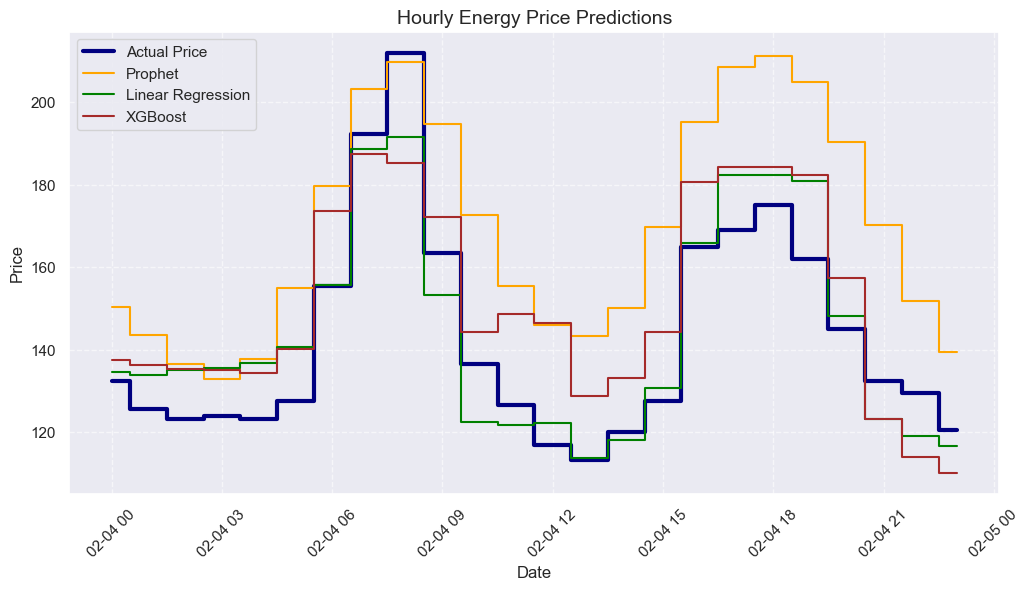

 63%|██████▎   | 19/30 [22:18<13:10, 71.87s/it]

Prophet RMSE: 28.90500857049378
Linear Regression RMSE: 9.776520126073363
XGBoost RMSE: 15.160126514641336
--------------------------------------------------------

Date to predict:  2025-02-05 00:00:00


10:33:33 - cmdstanpy - INFO - Chain [1] start processing
10:34:21 - cmdstanpy - INFO - Chain [1] done processing


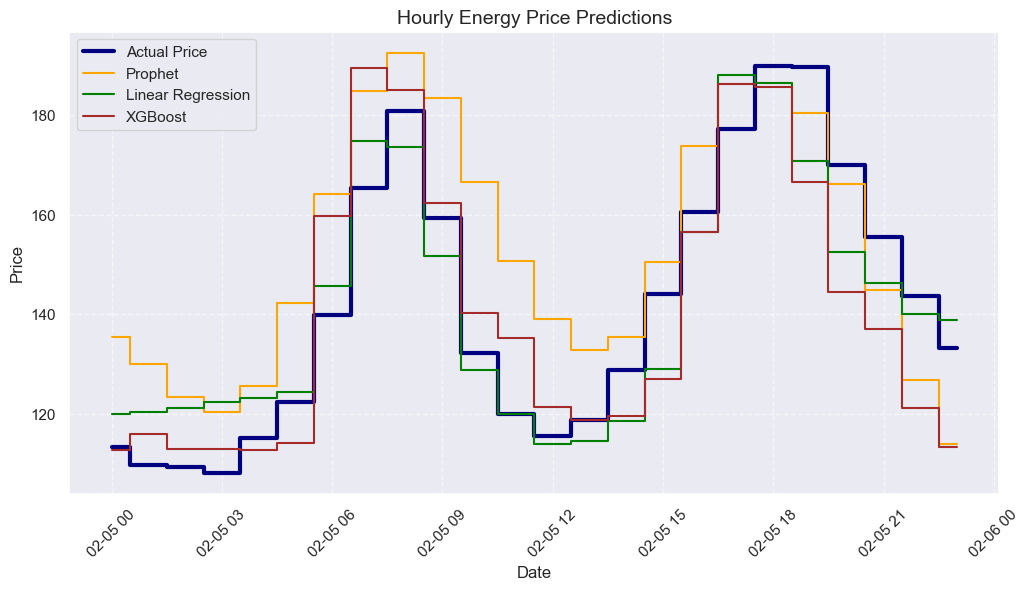

 67%|██████▋   | 20/30 [23:31<12:02, 72.26s/it]

Prophet RMSE: 17.71115534174229
Linear Regression RMSE: 9.373307296142348
XGBoost RMSE: 13.564761516137782
--------------------------------------------------------

Date to predict:  2025-02-06 00:00:00


10:34:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:33 - cmdstanpy - INFO - Chain [1] done processing


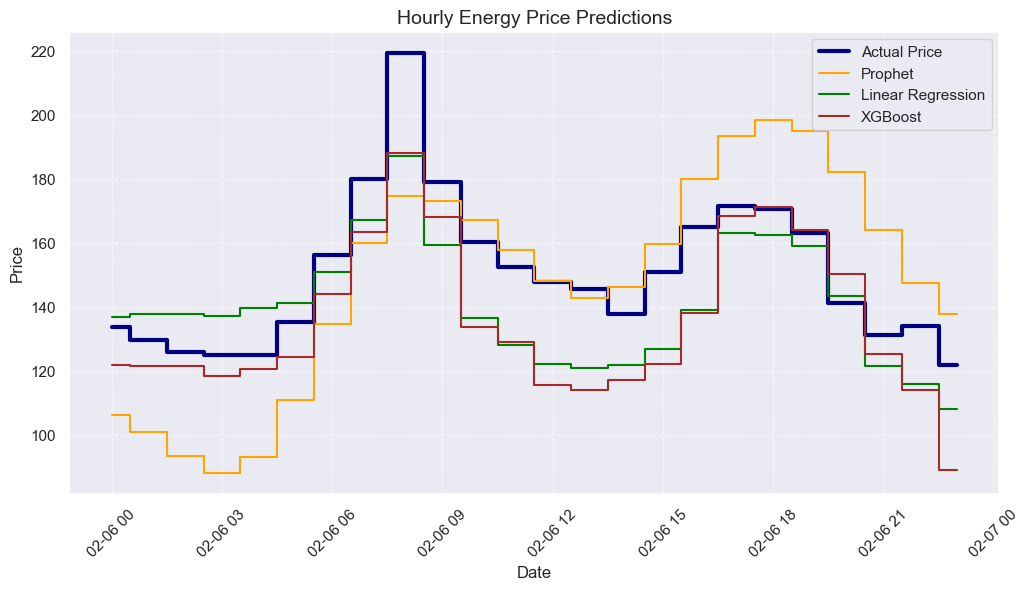

 70%|███████   | 21/30 [24:42<10:47, 71.92s/it]

Prophet RMSE: 24.52237690206887
Linear Regression RMSE: 16.991435661715677
XGBoost RMSE: 19.118389606392498
--------------------------------------------------------

Date to predict:  2025-02-07 00:00:00


10:35:57 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing


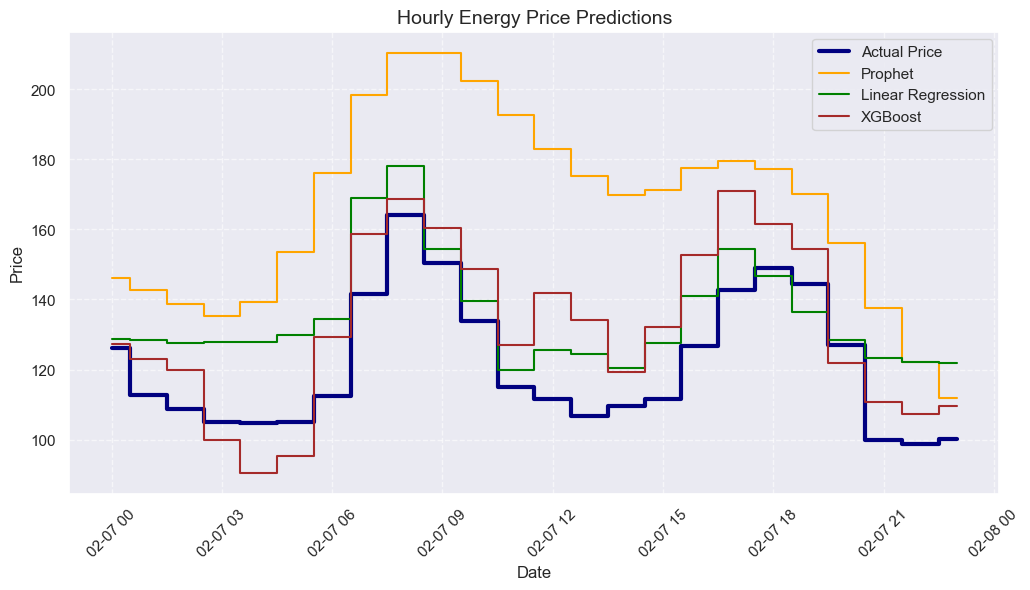

 73%|███████▎  | 22/30 [25:50<09:25, 70.74s/it]

Prophet RMSE: 48.2045438263551
Linear Regression RMSE: 16.622345836062916
XGBoost RMSE: 15.591675338930449
--------------------------------------------------------

Date to predict:  2025-02-08 00:00:00


10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:51 - cmdstanpy - INFO - Chain [1] done processing


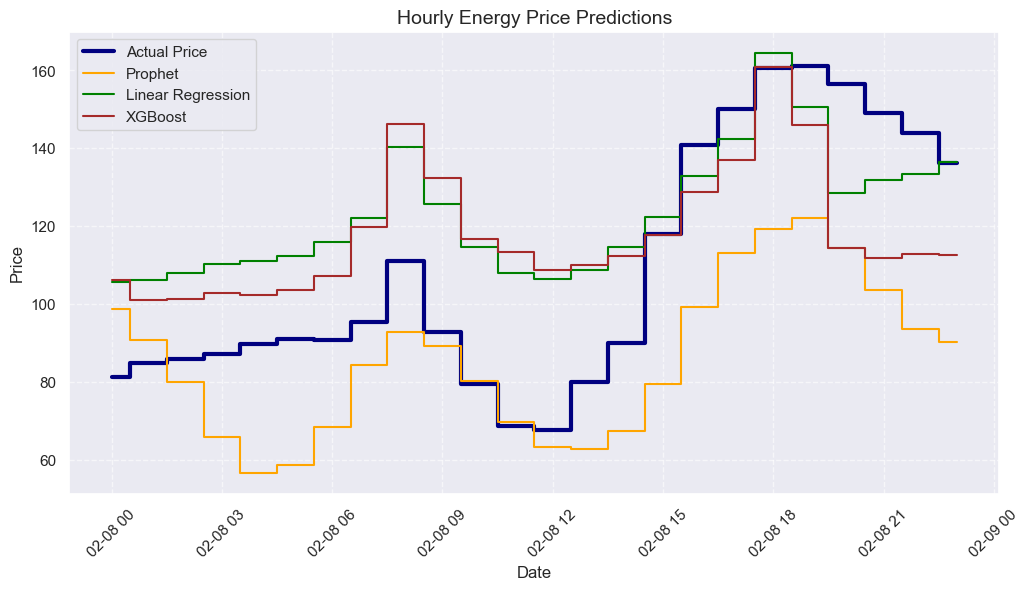

 77%|███████▋  | 23/30 [27:00<08:12, 70.35s/it]

Prophet RMSE: 29.612667021790017
Linear Regression RMSE: 23.656016680449916
XGBoost RMSE: 26.65194921703918
--------------------------------------------------------

Date to predict:  2025-02-09 00:00:00


10:38:15 - cmdstanpy - INFO - Chain [1] start processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing


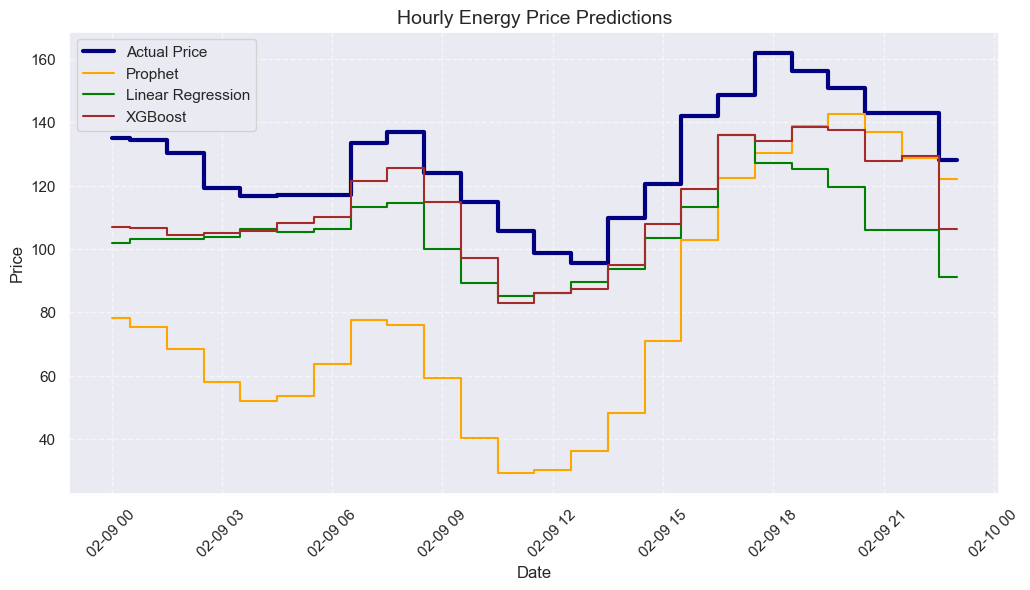

 80%|████████  | 24/30 [28:19<07:18, 73.05s/it]

Prophet RMSE: 52.495782033422756
Linear Regression RMSE: 24.92068924229876
XGBoost RMSE: 17.486051799945848
--------------------------------------------------------

Date to predict:  2025-02-10 00:00:00


10:39:34 - cmdstanpy - INFO - Chain [1] start processing
10:40:15 - cmdstanpy - INFO - Chain [1] done processing


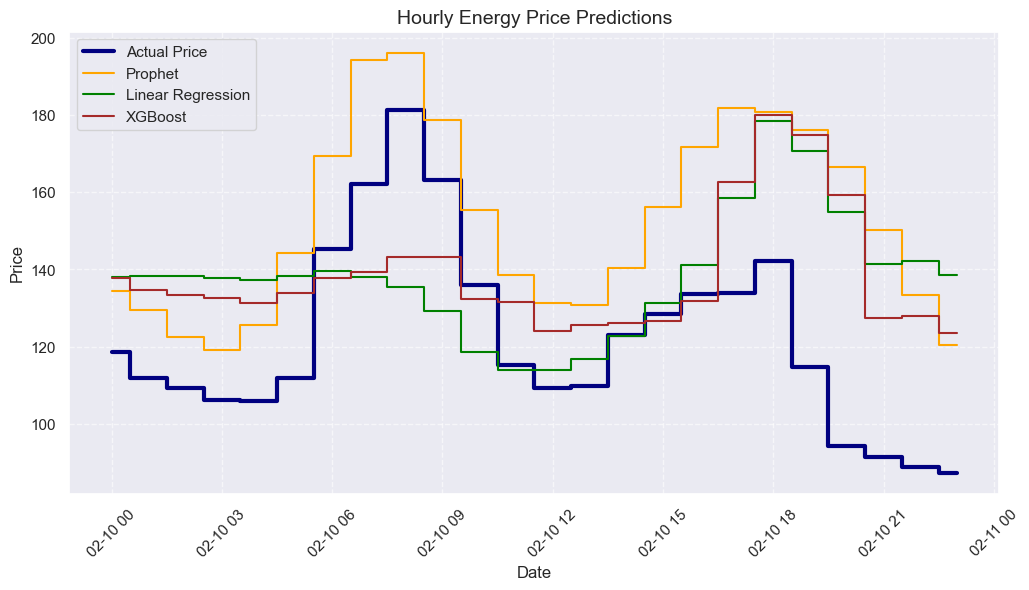

 83%|████████▎ | 25/30 [29:26<05:56, 71.21s/it]

Prophet RMSE: 34.19959768836742
Linear Regression RMSE: 32.63244334958947
XGBoost RMSE: 29.342748065295723
--------------------------------------------------------

Date to predict:  2025-02-11 00:00:00


10:40:41 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing


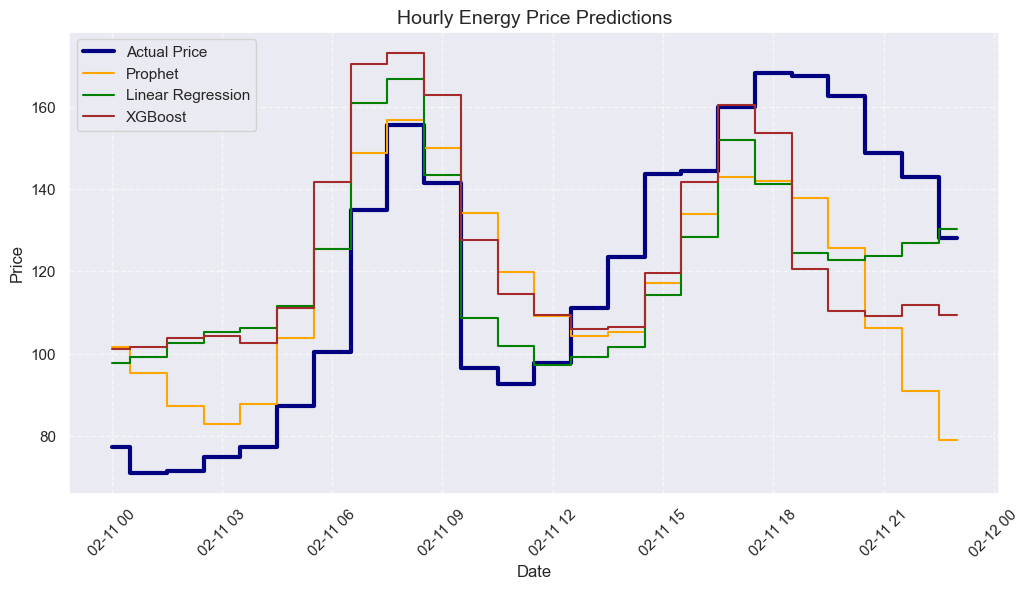

 87%|████████▋ | 26/30 [30:33<04:39, 69.99s/it]

Prophet RMSE: 26.111168601091602
Linear Regression RMSE: 23.276812063341236
XGBoost RMSE: 28.020706994492173
--------------------------------------------------------

Date to predict:  2025-02-12 00:00:00


10:41:48 - cmdstanpy - INFO - Chain [1] start processing
10:42:38 - cmdstanpy - INFO - Chain [1] done processing


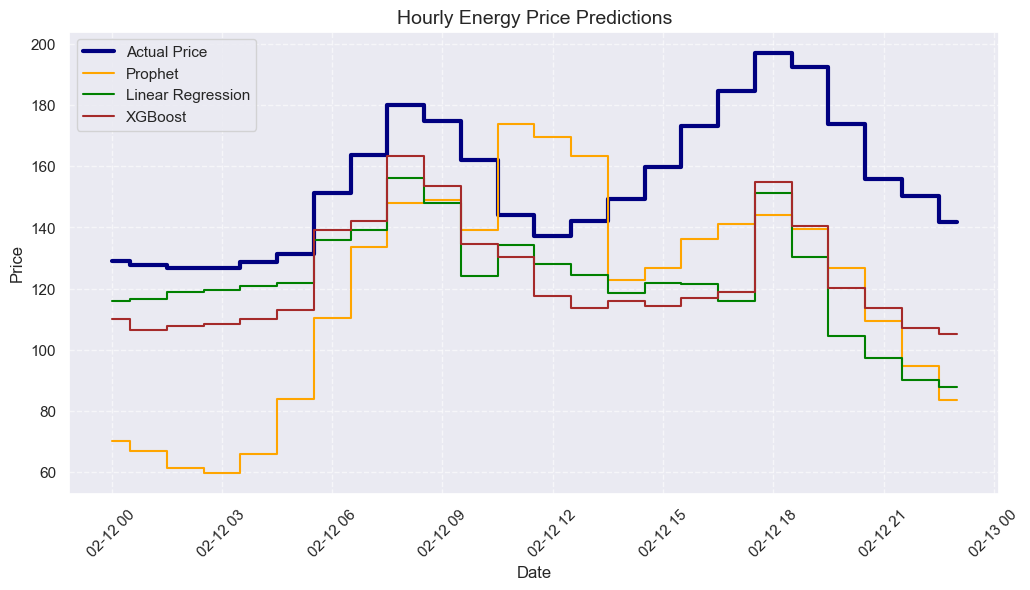

 90%|█████████ | 27/30 [31:49<03:35, 71.77s/it]

Prophet RMSE: 46.0669534956528
Linear Regression RMSE: 38.2870427704906
XGBoost RMSE: 34.61888152416206
--------------------------------------------------------

Date to predict:  2025-02-13 00:00:00


10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing


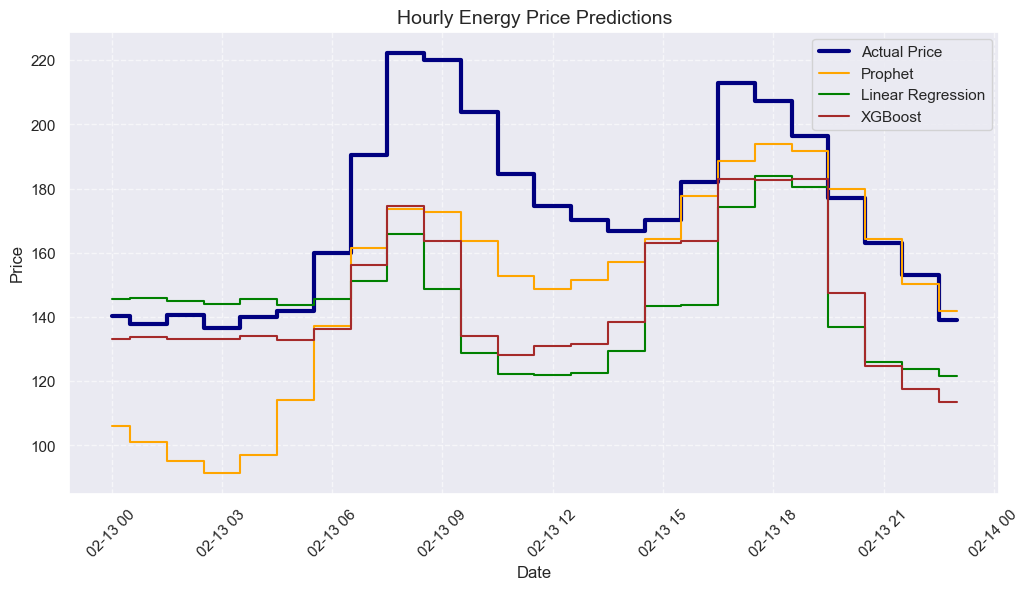

 93%|█████████▎| 28/30 [33:04<02:25, 72.61s/it]

Prophet RMSE: 28.7428100264323
Linear Regression RMSE: 38.05950955423733
XGBoost RMSE: 32.90503468237309
--------------------------------------------------------

Date to predict:  2025-02-14 00:00:00


10:44:19 - cmdstanpy - INFO - Chain [1] start processing
10:45:03 - cmdstanpy - INFO - Chain [1] done processing


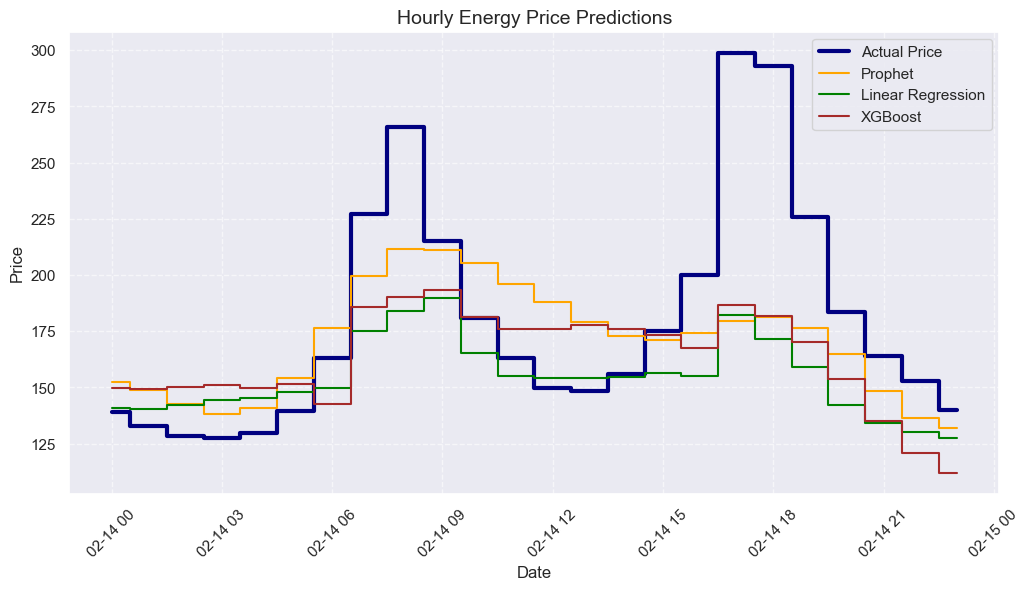

 97%|█████████▋| 29/30 [34:12<01:11, 71.29s/it]

Prophet RMSE: 40.87023360483619
Linear Regression RMSE: 45.586055488549405
XGBoost RMSE: 43.27205445720023
--------------------------------------------------------

Date to predict:  2025-02-15 00:00:00


10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:48:04 - cmdstanpy - INFO - Chain [1] done processing


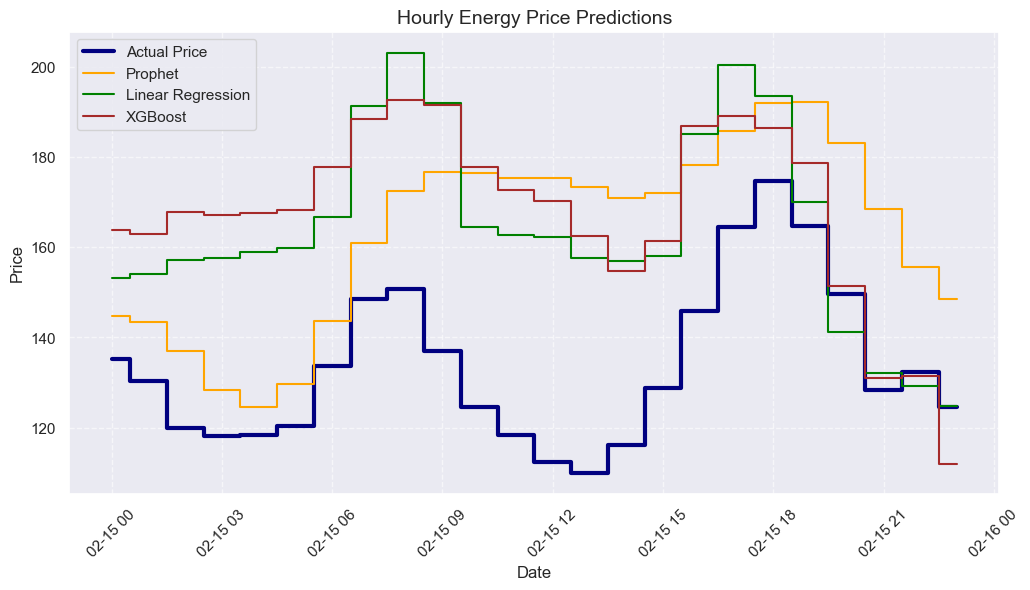

100%|██████████| 30/30 [37:12<00:00, 74.43s/it] 

Prophet RMSE: 34.32177204253352
Linear Regression RMSE: 35.2681765289877
XGBoost RMSE: 39.128757858444224
--------------------------------------------------------
Linear Regression: 35.58949765943713, XGBoost: 33.19503021498409

Average RMSEs - Prophet: 35.58949765943713, Linear Regression: 33.19503021498409, XGBoost: 30.083966027486333


In [17]:
WINDOW_SIZE = 24  # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "wind_speed_100m",
    "direct_radiation",
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "wind_speed_100m",
    "direct_radiation",
]

FINAL_FEATURES_XGB = [
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "temperature_2m",
    "wind_speed_100m",
    "hour",
    "dayofweek",
    "dayofyear",
    "ma_1_days",
    "ma_1_days_pumped_storage_generation",
    "ma_2_days",
    "ma_2_days_pumped_storage_generation",
    "ma_3_days",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_7_days",
    "ma_8_days_pumped_storage_generation",
    "ma_9_days_pumped_storage_generation",
    "ma_10_days",
    "ma_11_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days",
    "ma_14_days_pumped_storage_generation",
]

FINAL_FEATURES_PROPHET = [
    "hour",
    "ma_11_days",
    "ma_12_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days_pumped_storage_generation",
    "ma_1_days",
    "ma_2_days",
    "ma_2_days_pumped_storage_generation",
    "ma_3_days",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_6_days_pumped_storage_generation",
    "ma_8_days",
    "ma_8_days_pumped_storage_generation",
    "precipitation",
    "Solar",
    "temperature_2m",
    "Wind offshore",                    
    "Wind onshore"   
]

XGB_hyp_params = {
    "base_score":0.8431997016636286,
    "colsample_bylevel":0.5853713416705557,
    "early_stopping_rounds":60,
    "gamma":0.7345661820305603,
    "learning_rate":0.027037076338456208,
    "max_delta_step":10,
    "max_depth":41,
    "min_child_weight":10,
    "n_estimators":717,
    "subsample":0.555437341190683,
}

# =========================================================================
# 1. Data Preparation
# =========================================================================

# Get and split datasets
merged_df, _ = get_datasets()
train, eval, test, benchmark, _, _, _ = split(merged_df)

# Combine all available training data
training_set = pd.concat([train, eval, test])[COLUMNS]
# Benchmark dataset for rolling forecast
benchmarking_set = benchmark[COLUMNS]

# Lists to hold evaluation metrics for each window
rmses = []  # Will store tuples of (prophet_rmse, lr_rmse, xgb_rmse)

# =========================================================================
# 2. Rolling Forecast Loop
# =========================================================================

# We start from 24 hours in, to skip an initial period if needed
for window_start in tqdm(range(24, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE)):
    # Current forecast window for the next 24 hours
    y_actual = benchmarking_set.iloc[window_start : window_start + WINDOW_SIZE]["Price"]
    print("\nDate to predict: ", y_actual.index[0])

    # Extend the dataset with available data prior to the forecast window
    dataset_extended = pd.concat((training_set, benchmarking_set.iloc[:window_start]))
    next_day = dataset_extended.index[-1] + pd.DateOffset(hours=1)

    # If there's a gap in data, skip the forecast for this window
    if next_day != y_actual.index[0]:
        print(
            f"\nSkipping prediction for {next_day} due to missing entries.\n"
            "--------------------------------------------------------------\n"
        )
        continue

    # Extend the dataset by predicted values and samples if necessary
    dataset_extended_ps = extend_by_predictions_and_samples(
        dataset_extended, dataset_extended.index[-1]
    )

    # Create features required for model training and for predictions
    dataset_extended_features = create_features(dataset_extended_ps)

    # Split for training (all but last 24 hours) and prediction (the next 24 hours)
    VALIDATION_SET_SIZE = 24 * 14
    X_train_df = dataset_extended_features.iloc[:-WINDOW_SIZE - VALIDATION_SET_SIZE]
    X_eval_df = dataset_extended_features.iloc[-WINDOW_SIZE - VALIDATION_SET_SIZE : -WINDOW_SIZE]
    X_predict_df = dataset_extended_features.reindex(y_actual.index)

    # Prepare Prophet-compatible dataframe
    # Prophet requires 'ds' (date/time) and 'y' (target) columns.
    X_train_prophet = (
        X_train_df[["Price"] + FINAL_FEATURES_PROPHET]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )
    prophet_X_predict = X_predict_df[FINAL_FEATURES_PROPHET].reset_index().rename(columns={"index": "ds"})

    # =====================================================================
    # 2.1. Prophet Model
    # =====================================================================
    # If using a custom initialization, the function might set up seasonality, holidays, etc.
    prophet_model = init_prophet_model(FINAL_FEATURES_PROPHET)
    prophet_model.fit(X_train_prophet)

    # Generate a forecast. Adding constant to Prophet's forecast can offset a systematic bias.
    prophet_forecast = prophet_model.predict(prophet_X_predict)["yhat"] + 13

    # =====================================================================
    # 2.2. Linear Regression
    # =====================================================================
    lr = LinearRegression()
    lr.fit(X_train_df[FINAL_FEATURES_XGB], X_train_df["Price"])
    lr_forecast = lr.predict(X_predict_df[FINAL_FEATURES_XGB])

    # =====================================================================
    # 2.3. XGBoost
    # =====================================================================
    xgb_model = XGBRegressor(**XGB_hyp_params, n_jobs=8)
    xgb_model.fit(X_train_df[FINAL_FEATURES_XGB], X_train_df["Price"], eval_set=[(X_eval_df[FINAL_FEATURES_XGB], X_eval_df["Price"])], verbose=False)
    xgb_forecast = xgb_model.predict(X_predict_df[FINAL_FEATURES_XGB])

    # =====================================================================
    # 2.4. Plot Predictions
    # =====================================================================
    plot_benchmark_predictions(
        y_actual,
        X_predict_df,
        prophet_X_predict,
        prophet_forecast,
        lr_prediction=lr_forecast,
        xgb_prediction=xgb_forecast,
    )

    # =====================================================================
    # 2.5. Compute Metrics
    # =====================================================================
    prophet_rmse = np.sqrt(mean_squared_error(y_actual, prophet_forecast))
    lr_rmse = np.sqrt(mean_squared_error(y_actual, lr_forecast))
    xgb_rmse = np.sqrt(mean_squared_error(y_actual, xgb_forecast))

    # Print metrics for this window
    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}")
    print("--------------------------------------------------------")

    # Accumulate metrics for later averaging
    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =========================================================================
# 3. Compute Average Metrics and Print Results
# =========================================================================

if rmses:
    avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
    print(
        f"Linear Regression: {avg_rmse[0]}, XGBoost: {avg_rmse[1]}"
    )
    print(
        f"\nAverage RMSEs - Prophet: {avg_rmse[0]}, "
        f"Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}"
    )
else:
    print("No forecasts were computed. Check data availability and index alignment.")

## 7. Result

### Initial Model Testing  

We began our analysis by testing three different models—Linear Regression, XGBoost, and Prophet—to determine the most effective approach for forecasting energy prices.  

- To establish a baseline, we initially evaluated these models using only historical price data without any additional features.  
- Following this assessment, we introduced external features to enhance predictive accuracy.  

### Feature Impact  

We tested different feature sets to assess their impact on model performance (models without further hyperparameters):  

1. Energy Mix Features Only  
2. Weather Features Only  
3. Combination of Energy Mix and Weather Features  

| Model            | Weather Variables | Energy Mix Variables | Combined   |
|-----------------|------------------|----------------------|----------------------|
| Prophet      | 27.64296                | 21.64449                    | 20.34853   |
| Linear Regression | 27.59678         | 31.00825             | 24.65667
| XGBoost      |  41.91715        | 83.92071             | 35.84758    | 


Both feature sets individually improved model accuracy, but the best results were achieved when combining energy mix and weather features.  

### AutoML for Feature Selection  

To further refine the models, we applied an AutoML process to:  

- Automatically identify the most relevant variables.  
- Eliminate features that contributed little to predictive accuracy.  

This feature selection step significantly improved performance across all three models.  

### Hyperparameter Optimization  

After finalizing the feature set, we conducted a second AutoML process to optimize hyperparameters for XGBoost and Prophet.  

### Model Performance Evaluation  

With the optimized models in place, we compared their final performance using MAE, MSE, RMSE, and MAPE.  

- Prophet performed the worst, showing the highest RMSE and MAE among all three models.  
- Linear Regression also struggled but performed slightly better than Prophet.  
- XGBoost outperformed both models, achieving the lowest RMSE and MAE, making it the most reliable choice for our forecasting needs.  

### Final Model Selection  

Prophet, despite its ability to model seasonality, trends, and external variables, failed to deliver accurate predictions in our scenario. Its high error rates and reliance on unavailable data made it impractical.  

Given these results, we selected XGBoost as our final model to predict the energy price for February 18th, as it consistently provided the most accurate forecasts.

## Final Prediction 18.02.2025 00:00:00 - 19.02.2025 00:00:00

CSV found. Last date in file: 2025-02-17. Fetching missing weeks from 2025-02-18...
Fetched 168 rows for week starting 2025-02-17.
Appended 168 new rows. Final dataset contains 55962 rows.
Update complete.
No new data added.
Historical data appended to ./data/germany_weather_average.csv.


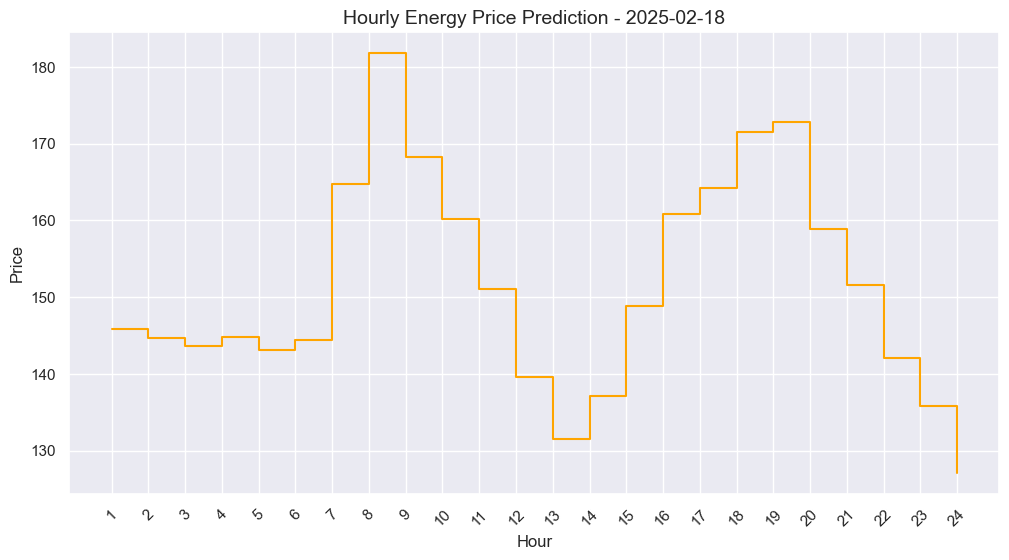

In [18]:
start_date = '2025-02-18 00:00:00'
end_date = '2025-02-18 23:00:00'

update_e_price_data()
update_e_mix_data()
fetch_historical_weather()

fill_up_e_prices(end_date)
fill_up_energy_mix(end_date)
fetch_forecast_and_update_csv(end_date)

# Columns to use from the datasets
COLUMNS = [
    "Price",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation",
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "Hydro",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "direct_radiation",
    "hour",
    "dayofweek",
    "ma_1_days",
    "ma_1_days_pumped_storage_generation",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_8_days",
    "ma_8_days_pumped_storage_generation",
    "ma_10_days",
    "ma_11_days",
    "ma_12_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days",
    "ma_14_days",
    "ma_14_days_pumped_storage_generation"
]

# =============================================================================
# Data Preparation
# =============================================================================
merged_df, _ = get_datasets(predict=True)

# Extend the training data with any benchmarking data available before the current window.
feature_df = create_features(merged_df[COLUMNS])

# Split the data into training and benchmarking sets
training_set = feature_df.loc[:start_date]
prediction_set = feature_df.loc[start_date:end_date]

# Prepare the training data for XGBoost.
X_train = training_set.iloc[:-30][FINAL_FEATURES]
X_eval = training_set.iloc[-30:][FINAL_FEATURES]
y_train = training_set.iloc[:-30]["Price"]
y_eval= training_set.iloc[-30:]["Price"]
X_predict = prediction_set[FINAL_FEATURES]

# ------------------------- XGBoost Model -------------------------
# Initialize the XGBoost model.

BEST_PARAMAS = {
    "base_score":0.8431997016636286,
    "colsample_bylevel":0.5853713416705557,
    "early_stopping_rounds":60,
    "gamma":0.7345661820305603,
    "learning_rate":0.027037076338456208,
    "max_delta_step":10,
    "max_depth":41,
    "min_child_weight":10,
    "n_estimators":717,
    "subsample":0.555437341190683,
}
xgb_model = XGBRegressor(**BEST_PARAMAS)

# Fit the XGBoost model and make predictions.
xgb_model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)
xgb_forecast = xgb_model.predict(X_predict)

# Prepare the forecast dataframe.
xgb_forecast_df = pd.DataFrame({
    "Hour": prediction_set.index,
    "Germany/Luxembourg in €/MWh": xgb_forecast
})
xgb_forecast_df.reset_index(drop=True, inplace=True)
xgb_forecast_df.index = xgb_forecast_df.index + 1
plot_final_prediction(xgb_forecast_df, start_date)

data_directory = os.path.join('data_science_challenge', 'data')
exampleDate = '2024-02-18'
output_dir=os.path.join(data_directory, exampleDate, "prediction.csv")

xgb_forecast_df.to_csv(output_dir, index=True, mode="w", index_label="Hour")



### 6. Conclusion

Our analysis revealed several key insights about energy price forecasting. One of the most surprising findings was that hourly moving averages did not improve model performance. This was due to the fact that they had to be calculated from sampled data for the 24h that were to be predicted. While moving averages are commonly used to smooth short-term fluctuations, they rely on future observations, which are unavailable in a true forecasting scenario. This limitation made them ineffective for our models. However, daily moving averages, especially those spanning over multiple days did improve the model.

Another significant result was the correlation between renewable energy generation and energy prices. As the share of renewable increased, prices tended to decrease, highlighting the impact of renewable energy sources on market dynamics. Additionally, we found that incorporating weather and energy mix features significantly improved forecasting accuracy, as reflected in the reduction of RMSE across all models. These external factors provided crucial information about supply and demand fluctuations, making them essential for accurate price predictions.

We also discovered that some months are easier to predict than others. For example, December was easier to forecast than January. Similarly, certain time periods, such as daytime, were more nighttime, likely due to more stable demand patterns. Both XGBoost and Prophet performed well in capturing trends and spikes, but they consistently exhibited slight shifts, particularly around sharp price spikes.

Additionally, we found that our predictions are not deterministic. This is probably due to the fact that for the moving averages, the missing energy prices have to be sampled. This may result some variation on the models predictions.

Among the models tested, XGBoost emerged as the best performer, achieving the lowest average RMSE in our specific scenario. While Prophet demonstrated superior accuracy in ideal conditions due to its ability to model seasonality, trends, and external regressors, its performance relied on the availability of the energy mix forecast, which is published too late to take it into account for the challenge. Without this crucial feature, XGBoost outperformed Prophet, making it the more reliable choice for our forecasting task. Given these constraints, we selected XGBoost as our final model.

For further improvements, several steps could be taken. One important enhancement would be to incorporate gas prices, as these external economic factors have a direct influence on energy markets. Adding such indicators could provide a more comprehensive view of price fluctuations. Additionally, increasing the amount of historical data available for training could further improve model performance by capturing long-term trends and rare market conditions.

Another key improvement would be further optimization through AutoML. We encountered challenges in efficiently utilizing all available CPU cores, particularly because Prophet is single-threaded, making it computationally expensive. Ensuring proper multi-threading capabilities for Prophet could significantly reduce training times. AutoML, while beneficial for feature selection and hyperparameter tuning, had a very high runtime, which limited its full potential. Addressing these computational constraints could lead to even better model performance and efficiency.

By expanding the dataset, integrating more relevant features, optimizing computational resources, and leveraging AutoML more effectively, the accuracy and robustness of our forecasts could be further enhanced, making the predictions even more reliable.